# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [211]:
#Reading in the libraries and the the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import re
import math
import json

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Getting to know the data

### Portfolio dataframe

In [212]:
#Size and shape of portfolio df
print(portfolio.shape)
portfolio

(10, 6)


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [213]:
#Null values per column
portfolio.isna().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

### Profile dataframe

In [214]:
#Size and shape of profile df
print(profile.shape)
profile.sample(10)

(17000, 5)


,age,became_member_on,gender,id,income
16308,82,20171106,F,6da8765ed47745959fd67865d3799206,84000.0
686,93,20131025,F,c1e4888e931740838f7ef3bbd04a114c,48000.0
13367,55,20180319,F,4fe72daa82624a3e8970d096f5f72f25,46000.0
16346,61,20170402,F,25c258df0487470c8d1cfed9feca14cd,119000.0
1940,41,20180203,M,220b34699e5b45d2839a02f333afcbec,35000.0
7082,74,20160308,F,cc3f80ea78da4d6085c8e90be8c67f47,115000.0
8111,18,20180120,M,c2b8b11520d4477cb997ebe61aa8a51f,34000.0
8207,60,20170930,M,5d83a12dcf044d6fa1b5ee3f2fe91bcc,42000.0
12588,57,20171114,M,c84d413645104090bf2883a2c67a31b1,109000.0
4345,66,20180219,M,d0fd792593d641caa5ff86ca26985604,70000.0


In [215]:
#Null values per column
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [216]:
#Statistics
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


M    8484
F    6129
O     212
Name: gender, dtype: int64


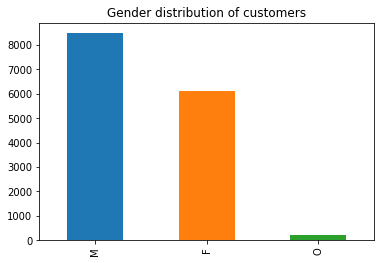

In [217]:
#Breakdown of profiles by gender
print(profile.gender.value_counts())
profile.gender.value_counts().plot(kind = 'bar', title = 'Gender distribution of customers')

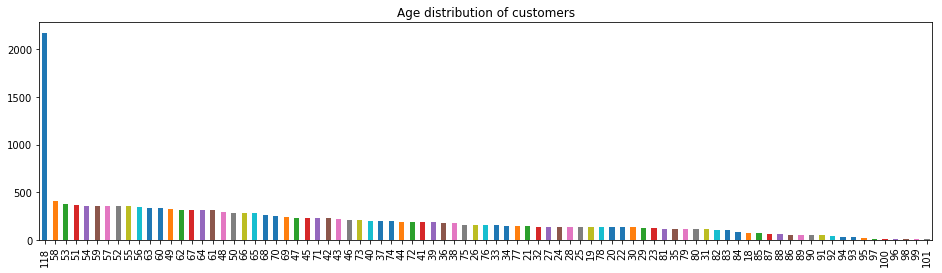

In [218]:
#Distribution of ages in the profile dataframe
age_dist=profile.age.value_counts()
plt.figure(figsize=(16,4))
age_dist.plot(kind='bar', title="Age distribution of customers")

In [219]:
#A closer look at the 118 year-old age group
pd.DataFrame(age_dist).sort_values(by = 'age', ascending = False).head(10)

,age
118,2175
58,408
53,372
51,363
54,359
59,359
57,353
52,351
55,350
56,342


In [220]:
#Looks like all the 118 year_olds do not have both gender and income values
profile[profile['age'] == 118].sample(10)

,age,became_member_on,gender,id,income
15060,118,20170531,None,ca7869c969344253bee98344942642e0,NaN
3122,118,20170815,None,bc98025ca6a1476887adb6ab925e8b0f,NaN
11278,118,20160527,None,5709166b8a4f46d0bc32db8b85e2d6fb,NaN
2072,118,20160131,None,6c40d0aacba44dec9f473c8e4f220936,NaN
4003,118,20160826,None,6b68eed636f049968e3d32267cc31658,NaN
3836,118,20170207,None,3ebc60e3aaaa41039128482c7296da53,NaN
14920,118,20180702,None,6beb1072bbd5438c83dd0bde66d7261d,NaN
16839,118,20180626,None,d6063a30185b4e60b58a445bacec5f56,NaN
544,118,20180722,None,30157b7fc37f43f2ae7ccd9edfe0b672,NaN
3666,118,20180215,None,12da1e886d0c405299369ee3f0d975e1,NaN


In [221]:
#Confirming that grouping the 118 year-olds by gender and income produces and empty dataframe
print(profile[profile['age'] == 118].groupby(['gender','income']).count())

Empty DataFrame
Columns: [age, became_member_on, id]
Index: []


Text(0,0.5,'No. of customers')

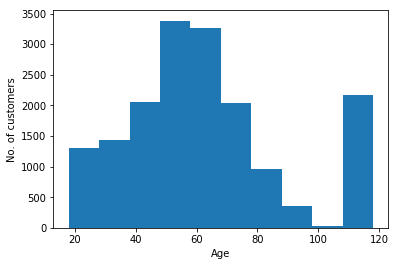

In [222]:
plt.hist(profile.groupby('id')['age'].sum())
#plt.title("Customer age groupings")
plt.xlabel("Age")
plt.ylabel("No. of customers")

Text(0,0.5,'No. of customers')

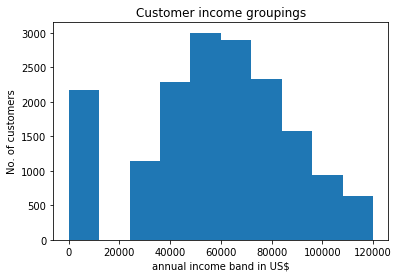

In [223]:
#Looking at the grouping of the income of customers
plt.hist(profile.groupby('id')['income'].sum())
plt.title("Customer income groupings")
plt.xlabel("annual income band in US$")
plt.ylabel("No. of customers")

### Transcript dataframe

In [224]:
#Size and shape of profile df
print(transcript.shape)
transcript.sample(10)

(306534, 4)


,event,person,time,value
271008,transaction,8a60eeb9a6184dd9a19075aebbc1ec71,594,{'amount': 21.29}
104331,transaction,b2460375ecd44b52b89ea7a45d116d37,294,{'amount': 2.09}
20406,offer viewed,126e7904f9114eff8bead85a217ffb85,18,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
280552,offer completed,731cf81d68a641019a2da3fc97459223,618,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
6884,offer received,8da7dbbe9db544c994ef7ee31cfadd60,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
269425,transaction,d438a838e9f74fa99c3a53f53d73afd4,594,{'amount': 23.29}
167539,transaction,e8926849bbe24ce488d4f3fcd3b537e8,408,{'amount': 14.45}
28164,offer viewed,5ecaea5c8bf44ae4a65838d9d066c909,42,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
34365,transaction,3083b4b83d3c436d90fb41297da0e9d3,66,{'amount': 5.39}
245185,offer received,0ba6e2ad781c4429afd26cf0b35f2d11,576,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}


In [225]:
#Null values per column
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [226]:
#Distribution of the event types
transcript.groupby('event').count()

,person,time,value
event,,,
offer completed,33579,33579,33579
offer received,76277,76277,76277
offer viewed,57725,57725,57725
transaction,138953,138953,138953


Text(0.5,1,'Distribution of event types')

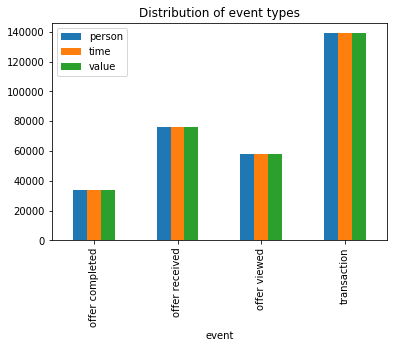

In [227]:
#Plotting distribution of the event types
transcript.groupby('event').count().plot(kind = 'bar')
plt.title('Distribution of event types')

In [228]:
#Checking if there are frequent customers in the data
pd.DataFrame(transcript.groupby('person')['event'].count().sort_values(ascending=False)).head(30)

,event
person,
94de646f7b6041228ca7dec82adb97d2,51
8dbfa485249f409aa223a2130f40634a,49
79d9d4f86aca4bed9290350fb43817c2,48
d0a80415b84c4df4908b8403b19765e3,48
5e60c6aa3b834e44b822ea43a3efea26,48
a42ed50acc4d4b25bca647c9e0b916ad,46
b1f4ece7d49342628a9ed77aee2cde58,46
28681c16026943e68f26feaccab0907f,46
bd2cdd691aca4bb0a0e039979ee5de5c,46


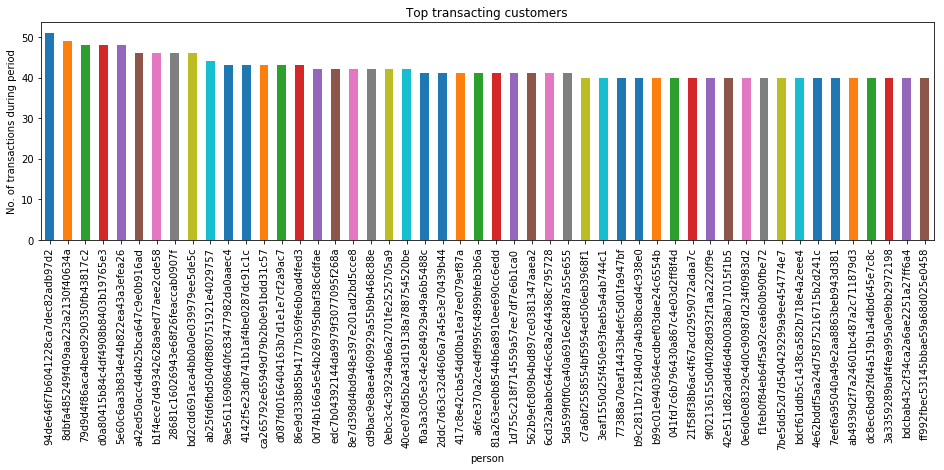

In [229]:
plt.figure(figsize=(16,4))
(transcript.groupby('person')['event'].count().sort_values(ascending = False).head(50)).plot(kind='bar')
plt.title("Top transacting customers")
plt.ylabel('No. of transactions during period')
plt.show()

The graph shows that there are a number of customers who have a large number of transactions during the period. I will keep this in mind and watch out for possible skewing of the analysis for a customer category based on a few high transactors.

# Business questions and the intent of the analysis 

Now that I have had a look at the data and understand it's structure and attributes at a high level I am more confident of coming up with the business questions that I want my analysis to answer.

I am not going to use machine learning algorithms to make predictions. However, my analysis will focus on building a set of heuristics based on the performance of each offer for a given profile of customer. I will achieve this by, firstly, placing the customers into logical categories according to the following features:

- age_band: Youth, Early adulthood, Early Middle Age, Middle Age, Late Middle Age, Senior
- income_band: Low, Low-middle, Upper-middle, High
- membership_class: Bronze, Silver, Gold, Platinum, Diamond
- gender: M, F

The data preparation section will help in making sure that the data is in a format that allows me to correctly categorize the customers in the correct bucket based on the above groupings. The spread of the data will also guide the size of each classification under a feature.

The last section will present the actual analysis to identify and identify a set of heuristics across the different features that Starbucks should be targetting with each offer type, and also those that it should probably not be targeting as much.

The analysis will focus on answering the following questions:

#### Question 1: 
Which customer archetype (age band, income band, membership_class, and gender) most viewed an offer type - find this for each offer type?

#### Question 2:
Which customer archetype is most influenced to complete an offer type - find this for each offer type

#### Question 3:
    
Which customer archetype would spend anyway without the offer - find this for each offer type

# Preparing the data

### Portfolio dataframe

- I am going to add an offer name for each different offer. The offer is a concatenation of the columns 'offer_type', 'reward', 'difficulty', and 'duration'
- I will rearaange the columns for ease of reference according to how I will be using the data
- Add a duration in minutes column to match the transcript dataframe 'time' column

In [230]:
#Add table name column
portfolio['offer_name'] = portfolio['offer_type'].astype(str) + '_' + portfolio['reward'].astype(str) + '_' + portfolio['difficulty'].astype(str) + '_' + portfolio['duration'].astype(str)

In [231]:
#Duration in minutes
portfolio['duration_in_hours'] = (portfolio.duration * 24)

In [232]:
#Rearrange order of columns for ease of reference
portfolio = portfolio[['offer_name', 'id', 'offer_type', 'reward', 'difficulty', 'duration', 'duration_in_hours', 'channels']]

In [233]:
#Creating dummy variables from the 'channels' column 
portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [234]:
portfolio = portfolio.drop('channels', axis=1)

In [235]:
portfolio

,offer_name,id,offer_type,reward,difficulty,duration,duration_in_hours,email,mobile,social,web
0,bogo_10_10_7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,10,7,168,1,1,1,0
1,bogo_10_10_5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,10,5,120,1,1,1,1
2,informational_0_0_4,3f207df678b143eea3cee63160fa8bed,informational,0,0,4,96,1,1,0,1
3,bogo_5_5_7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,5,7,168,1,1,0,1
4,discount_5_20_10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,20,10,240,1,0,0,1
5,discount_3_7_7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,7,7,168,1,1,1,1
6,discount_2_10_10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,10,10,240,1,1,1,1
7,informational_0_0_3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,3,72,1,1,1,0
8,bogo_5_5_5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,120,1,1,1,1
9,discount_2_10_7,2906b810c7d4411798c6938adc9daaa5,discount,2,10,7,168,1,1,0,1


### Profile dataframe

- I will drop the rows with the suspicious looking age of 118 years and missing gender and income values. My analysis will be based on these 3 columns and the membership length, so if I do not have or cannot trust the data in these columns I cannot use them

I would have prefered to try to use the data somehow but since I do not know why these profiles do not have the information I require it would be misleading to make assumptions. These profiles may be anything, i.e., guest customers on the app who have not created a profile, or a Starbucks staff transacting for customers who do not have an app, or child accounts somehow linked to the parents accounts. They could be anything, and without enough background information I cannot make assumptions.

In [236]:
#drop 118 year-old customer rows
profile = profile.drop(profile[profile.age == 118].index)
profile.shape

(14825, 5)

- I will add the 'year_of_membership' and 'membership_class' columns, and drop the became member on column since I am not using it
The membership class is a way of classifying customers based on the length of membership they have with Starbucks i.e., as determined by their joining year.

Since the latest member became a member in 2018 I am going to regard this customer as having 1 year of membership. Therefore I work backwards from this base to get the membership length.

Classification categories are as follows:
- 1st year of membership: Bronze
- 2nd year of membership: Silver
- 3rd year of membership: Gold
- 4th year of membership: Platinum
- 5th year + of membership: Diamond

In [237]:
profile.head()

,age,became_member_on,gender,id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [238]:
#Range between newest longest member joining date and newest member joining date
profile.became_member_on.min(), profile.became_member_on.max()

(20130729, 20180726)

In [239]:
#Getting the year of membership for each customer
profile['year_of_membership'] = ((profile.became_member_on.astype(str)).str[:4]).astype(int)
profile = profile.drop('became_member_on', axis=1)

In [240]:
profile.head()

,age,gender,id,income,year_of_membership
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017
5,68,M,e2127556f4f64592b11af22de27a7932,70000.0,2018
8,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018
12,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017


In [241]:
#Define function to assign membership class as per table
def condition_membership_class(x):
    if x>=2018:
        return "Bronze"
    elif x==2017:
        return "Silver"
    elif x==2016:
        return "Gold"
    elif x==2015:
        return "Platinum"
    else:
        return "Diamond"

In [242]:
#Apply condition function
profile['membership_class'] = profile.year_of_membership.apply(condition_membership_class)

In [243]:
#View sample
profile.sample(5)

,age,gender,id,income,year_of_membership,membership_class
14453,50,F,b83015754a8f40039405b5edd29252b2,33000.0,2018,Bronze
12724,55,M,5f387e6735474f63af34bf59f73c5124,34000.0,2016,Gold
8669,19,F,f052f7c3f89044f9bb7097a72e62101c,55000.0,2018,Bronze
8554,21,O,66412cc34dd640749fa80e5b8d4d8d18,45000.0,2015,Platinum
8906,67,M,9eac14a099914474a4b2f04b91e3b90d,51000.0,2018,Bronze


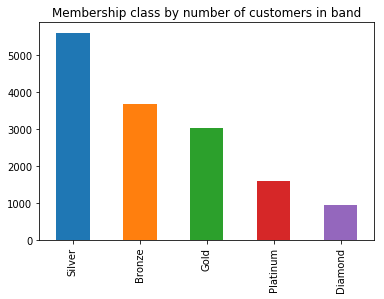

In [244]:
profile.membership_class.value_counts().plot(kind='bar', title = "Membership class by number of customers in band")

In [245]:
profile.membership_class.value_counts()

Silver      5599
Bronze      3669
Gold        3024
Platinum    1597
Diamond      936
Name: membership_class, dtype: int64

Seeing that there is an uneven distribution in the number of customers across the membership class bands I will use some normalization tactic when interpreting the data in later sections.

- I will categorize the income into bands as per the table below. These income bands are based on subjective analysis of the income data of the Starbucks customers profile data and the statistics from the data in the section above.

Income range	Lower band (US$)	Upper band (US$)
High	80001	-
Upper-middle	64001	80000
Low-middle	49001	64000
Low	-	49000
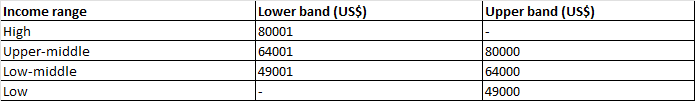

In [246]:
#Define function to assign income range as per above
def condition_income(x):
    if x>80000:
        return "High"
    elif x>64000 and x<=80000:
        return "Upper-middle"
    elif x>49000 and x<=64000:
        return "Low-middle"
    else:
        return "Low"

In [247]:
#Apply the conditions
profile['income_band'] = profile.income.apply(condition_income)
profile.sample(5)

,age,gender,id,income,year_of_membership,membership_class,income_band
11838,34,M,5e5cd2f11f6642aa9dbe82854d77ef34,37000.0,2017,Silver,Low
14215,57,M,dea843d6482744aaa7504f0e0cfa8e77,65000.0,2017,Silver,Upper-middle
12099,77,M,5d3f09e7ccb5466d875925d63db35f72,84000.0,2016,Gold,High
15511,22,M,6efb398bbf994e2390f7f5063fb54702,35000.0,2013,Diamond,Low
16269,67,M,f3b303726eba48edb0f89740422cfb8d,88000.0,2016,Gold,High


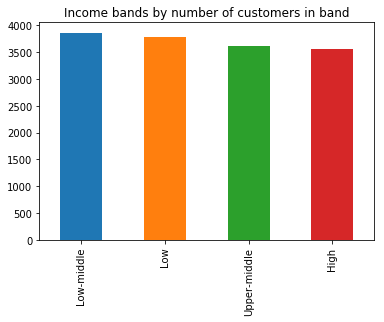

In [248]:
#looking at the breakdown of customers by income
profile.income_band.value_counts().plot(kind='bar', title = "Income bands by number of customers in band")

- I will classify age ranges into the bands shown on the table below. These age classification bands are based on subjective analysis of the age data in the Starbucks' profile data set, but also influence by the 'Life satisfaction across four stages of adult life' produced by the Int J Aging Hum Dev organisation (https://pubmed.ncbi.nlm.nih.gov/7203662/#:~:text=The%20stages%20of%20adulthood%20examined,(ages%2065%20and%20older))

Age range	Lower band (years old)	Upper band (years old)
Senior	66	-
Late Middle Age	56	65
Middle Age	46	55
Early Middle Age	36	45
Early Adulthood	26	35
Youth	-	25
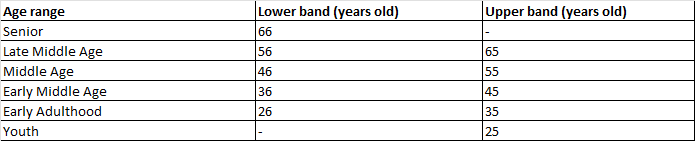

In [249]:
#Define function to assign age range classification as per above table
def condition_age(x):
    if x>66:
        return "Senior"
    elif x>55 and x<=65:
        return "Late Middle Age"
    elif x>46 and x<=55:
        return "Middle Age"
    elif x>35 and x<=45:
        return "Early Middle Age"
    elif x>25 and x<=35:
        return "Early Adulthood"
    else:
        return "Youth"

In [250]:
#Apply the conditions
profile['age_band'] = profile.age.apply(condition_age)
profile.sample(5)

,age,gender,id,income,year_of_membership,membership_class,income_band,age_band
857,47,M,9e784b0f6f3c412db22ad03f7a415f31,92000.0,2018,Bronze,High,Middle Age
13687,62,F,bda8280eee0249cb9a4b282a993aaafd,71000.0,2016,Gold,Upper-middle,Late Middle Age
401,58,F,78364f0145d342c2bd44a169cfb9c332,58000.0,2016,Gold,Low-middle,Late Middle Age
2554,73,F,0e7e49b5e82f4003a070c7ba7e5c41ba,83000.0,2016,Gold,High,Senior
16134,68,M,fdc10e59f04044159c5ddd72d76b1955,68000.0,2018,Bronze,Upper-middle,Senior


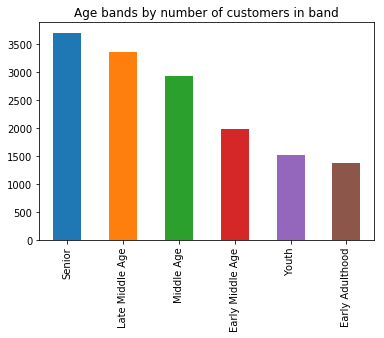

In [251]:
#looking at the breakdown of customers by age
profile.age_band.value_counts().plot(kind='bar', title = "Age bands by number of customers in band")

Seeing that there is an uneven distribution in the number of customers across the different age bands I will use some normalization tactic when interpreting the data in later sections.

### Afterthought on gender classification 'O' after initial analysis

Initially I had kept gender classification 'O' as a valid option, but being such a small number (212 out of 17 000 records) their response to offers was skewing the statistics on analysis by gender. For example, being a small proportion of the entire dataset, if 5 out of 5 of them respond to an offer that represents a 100% response rate for them. But should they be targeted for a similar offer at the expense of a larger gender grouping with. say, 90% response rate out of 6129 individuals?

It is a subjective call, but with my analysis based on the significance of numbers within a category I later decided to assimilate the 'Other' gender classification data into either male (M) or female (F) through random allocation.

I chose this option as opposed to dropping the records altogether because, unlike the 118 year-olds, all the other information for this group is available and can still be relevant in the analyis even with the slight distortion on the gender classification.

In [252]:
mylist = ['M','F']

np.random.seed(1)
m = profile['gender'].eq('O')
profile.loc[m, 'gender'] = np.random.choice(mylist, size=m.sum())

In [253]:
profile.gender.value_counts()

M    8590
F    6235
Name: gender, dtype: int64

In [254]:
profile.sample(5)

,age,gender,id,income,year_of_membership,membership_class,income_band,age_band
10145,37,M,c60f5cd0bdc64124bf1c206f9bf94c64,48000.0,2018,Bronze,Low,Early Middle Age
12048,48,F,6746ff7ff11040338898c98b10c84d05,79000.0,2018,Bronze,Upper-middle,Middle Age
7279,59,M,664cdcbcc8b442078bcedac94dc227bb,64000.0,2017,Silver,Low-middle,Late Middle Age
14571,49,M,63f15b2c4c504f119c5b0a7245d2d7e2,64000.0,2018,Bronze,Low-middle,Middle Age
14470,23,M,3f0081b6b7cb4ad4af44d3472e54da51,54000.0,2018,Bronze,Low-middle,Youth


### Transcript dataframe

-  I will extract the dictionary value portion in the 'trancript.value' column

In [255]:
#Extract value portion from value column dictionary values
transcript['value_only'] = transcript['value'].apply(lambda x : list(x.values())[0])

In [256]:
#Drop the original 'value' column
transcript = transcript.drop('value', axis=1)

In [257]:
transcript.sample(5)

,event,person,time,value_only
17883,offer viewed,b8b20565b580442cae83bb0933f9c145,6,2298d6c36e964ae4a3e7e9706d1fb8c2
7580,offer received,47f654b9ff57453d890a690bbb491d56,0,3f207df678b143eea3cee63160fa8bed
288314,transaction,714074e087534d908f4ca450f4efa52a,642,3.79
159512,offer received,9bd28ae809bb435b83f5bd94ed9aee4c,408,fafdcd668e3743c1bb461111dcafc2a4
86008,transaction,6966b1d94b8a48f3b0fbfd14dda579ac,216,12.37


Checking if the customers with age 118 years that I deleted from the profile dataframe have entries in transcript

In [258]:
#List of customers in profile dataframe
profile_ids = list()

In [259]:
#List of customers in transcript dataframe
transcript_persons = list(transcript.person)

In [260]:
#Check customers in transcript but not profile
len(list(set(transcript.person) - set(profile.id)))

2175

In [261]:
#Create list of customers to be removed from transcript
to_remove = list(set(transcript.person) - set(profile.id))

In [262]:
#remove entries from dropped customers
transcript = transcript[~transcript['person'].isin(to_remove)]

In [263]:
#New transcript shape
transcript.shape

(272762, 4)

I have dropped 33 772 entries from the original transcript dataframe belonging to the mysterious 118 year olds :(

In [264]:
transcript.event.value_counts()

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32444
Name: event, dtype: int64

### Merging and splitting the dataframes into logical data sets for the analysis

In [265]:
#Merge transcript and profile dataframes
transcript_profile = pd.merge(transcript, profile, how='outer', left_on='person', right_on='id', suffixes=('_t', '_p'), sort=True)

In [266]:
#Dropping 'id' column as it is a copy of the 'person' column
transcript_profile = transcript_profile.drop('id', axis=1)

In [267]:
print(transcript_profile.shape)
transcript_profile.sample(5)

(272762, 11)


,event,person,time,value_only,age,gender,income,year_of_membership,membership_class,income_band,age_band
1062,transaction,013094309e1b49e095c098df412d125d,312,0.5,58,M,54000.0,2014,Diamond,Low-middle,Late Middle Age
224292,offer viewed,d272e201f4e64fdbb129337e4139d812,354,ae264e3637204a6fb9bb56bc8210ddfd,26,F,38000.0,2016,Gold,Low,Early Adulthood
90621,transaction,54d9d921c59540fba0e5aea4b7079da0,120,22.13,70,F,62000.0,2017,Silver,Low-middle,Senior
264564,transaction,f86bf195d4dd453b9e5bee433fe4ae7f,318,2.6,59,M,31000.0,2015,Platinum,Low,Late Middle Age
66091,offer completed,3dc0ff03f78948c7b0c9db474bde3485,516,2298d6c36e964ae4a3e7e9706d1fb8c2,46,M,38000.0,2017,Silver,Low,Youth


In [268]:
transcript_profile.event.value_counts()

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32444
Name: event, dtype: int64

In [269]:
#Create seperate dataframes for transactions and offers from the transcript_profile dataframe
#Create transaction dataframe
transaction_df = transcript_profile.loc[transcript_profile['event'] == 'transaction']

In [270]:
#Rename 'value_only' to 'transaction_amount'
transaction_df = transaction_df.rename(columns={'value_only': 'transaction_amount'})

If transaction records have the same person, time and transaction_amount values, we can regard these as duplicates and drop the duplicate records, keeping only the first occurrence

In [271]:
#Dropping duplicates
transaction_df = transaction_df.drop_duplicates(subset=['person','time','transaction_amount'], keep='first')

In [272]:
#A look at the data
print(transaction_df.shape)
transaction_df.sample(5)

(123957, 11)


,event,person,time,transaction_amount,age,gender,income,year_of_membership,membership_class,income_band,age_band
201173,transaction,bba62984c3d347908b94f740ac02f623,162,16.57,63,M,50000.0,2017,Silver,Low-middle,Late Middle Age
137509,transaction,81a263ee0b8544b6a8910ee690cc6edd,330,4.24,41,F,55000.0,2015,Platinum,Low-middle,Early Middle Age
199471,transaction,ba0d778f5c5045d499cf42eeaa9f995e,354,1.95,24,M,54000.0,2014,Diamond,Low-middle,Youth
185342,transaction,acde96bfd1604c58a3f539029f98f122,366,1.25,45,M,52000.0,2018,Bronze,Low-middle,Early Middle Age
154095,transaction,90b9b612883340d683fdc1979dd79831,276,17.65,62,F,113000.0,2016,Gold,High,Late Middle Age


In [273]:
#Create offers dataframe
offers = transcript_profile.loc[transcript_profile['event'] != 'transaction']

In [274]:
print(offers.shape)
offers.sample(5)

(148805, 11)


,event,person,time,value_only,age,gender,income,year_of_membership,membership_class,income_band,age_band
247361,offer viewed,e7bd454cf43b436eb4668be7953033cd,516,ae264e3637204a6fb9bb56bc8210ddfd,20,M,70000.0,2018,Bronze,Upper-middle,Youth
44628,offer viewed,2b4bfbda411041ef84ee39bae91fb229,6,3f207df678b143eea3cee63160fa8bed,43,M,63000.0,2018,Bronze,Low-middle,Early Middle Age
143549,offer completed,87065822536a4ee182b931dc15c029be,36,2906b810c7d4411798c6938adc9daaa5,69,M,60000.0,2017,Silver,Low-middle,Senior
84058,offer viewed,4e898d4f879740d8a2d630b20f864b16,354,4d5c57ea9a6940dd891ad53e9dbe8da0,55,M,71000.0,2017,Silver,Upper-middle,Middle Age
162750,offer received,98b40e9108fa47cc9212edb544252f3b,576,fafdcd668e3743c1bb461111dcafc2a4,65,M,89000.0,2015,Platinum,High,Late Middle Age


In [275]:
#Merge the offers dataframe and the portfolio dataframe
offers_detailed = pd.merge(offers, portfolio, how='outer', left_on='value_only', right_on='id', suffixes=('_trans', '_prof'), sort=False)

In [276]:
#Dropping 'id' column as it is a copy of the 'person' column
offers_detailed = offers_detailed.drop('id', axis=1)

In [277]:
#Rename 'value_only' to 'offer_id'
offers_detailed = offers_detailed.rename(columns={'value_only': 'offer_id'})

If records in the offers_detailed dataframe have exactly the same 'event', 'person', 'time', and 'offer_id', then these transactions can be regarded as duplications and will be dropped from the analysis dataset, keeping only the first occurence of the record.

In [278]:
#Dropping duplicates
offers_detailed = offers_detailed.drop_duplicates(subset=['event','person', 'time', 'offer_id'], keep='first')

In [279]:
#A look at the data
print(offers_detailed.shape)
print(offers_detailed.event.value_counts())
offers_detailed.sample(5)

(148431, 21)
offer received     66501
offer viewed       49860
offer completed    32070
Name: event, dtype: int64


,event,person,time,offer_id,age,gender,income,year_of_membership,membership_class,income_band,...,offer_name,offer_type,reward,difficulty,duration,duration_in_hours,email,mobile,social,web
27395,offer received,487ad048c0e248a8bf6eb1545f5be4c6,408,f19421c1d4aa40978ebb69ca19b0e20d,28,F,75000.0,2017,Silver,Upper-middle,...,bogo_5_5_5,bogo,5,5,5,120,1,1,1,1
56505,offer viewed,ef14b3dc52ab4023857d5d20853eb5b8,678,fafdcd668e3743c1bb461111dcafc2a4,48,F,97000.0,2017,Silver,High,...,discount_2_10_10,discount,2,10,10,240,1,1,1,1
56230,offer received,eadded7715674f5baf27721e68c930e6,0,fafdcd668e3743c1bb461111dcafc2a4,54,F,86000.0,2017,Silver,High,...,discount_2_10_10,discount,2,10,10,240,1,1,1,1
55338,offer received,df0f7b3282b047b79713a6d86fbceba5,0,fafdcd668e3743c1bb461111dcafc2a4,75,M,89000.0,2016,Gold,High,...,discount_2_10_10,discount,2,10,10,240,1,1,1,1
93666,offer received,534adfdce3b64611953a0579c9a18844,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,67,F,41000.0,2017,Silver,Low,...,discount_5_20_10,discount,5,20,10,240,1,0,0,1


I am going to create a seperate dataframe for each offer event, i.e., offer_received_df, offer_viewed_df and offer_completed_df

In [280]:
#Creating the offer_received_df
offer_received_df = offers_detailed.loc[offers_detailed['event'] == 'offer received']
print(offer_received_df.shape)
offer_received_df.head(2)

(66501, 21)


,event,person,time,offer_id,age,gender,income,year_of_membership,membership_class,income_band,...,offer_name,offer_type,reward,difficulty,duration,duration_in_hours,email,mobile,social,web
0,offer received,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,33,M,72000.0,2017,Silver,Upper-middle,...,informational_0_0_3,informational,0,0,3,72,1,1,1,0
2,offer received,0011e0d4e6b944f998e987f904e8c1e5,336,5a8bc65990b245e5a138643cd4eb9837,40,M,57000.0,2018,Bronze,Low-middle,...,informational_0_0_3,informational,0,0,3,72,1,1,1,0


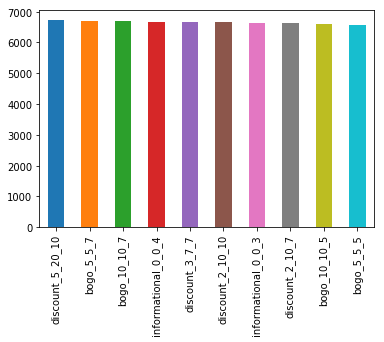

In [281]:
offer_received_df.offer_name.value_counts().plot.bar()

In [282]:
#Creating the offer_viewed_df
offer_viewed_df = offers_detailed.loc[offers_detailed['event'] == 'offer viewed']
print(offer_viewed_df.shape)
offer_viewed_df.head(2)

(49860, 21)


,event,person,time,offer_id,age,gender,income,year_of_membership,membership_class,income_band,...,offer_name,offer_type,reward,difficulty,duration,duration_in_hours,email,mobile,social,web
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,5a8bc65990b245e5a138643cd4eb9837,33,M,72000.0,2017,Silver,Upper-middle,...,informational_0_0_3,informational,0,0,3,72,1,1,1,0
3,offer viewed,0011e0d4e6b944f998e987f904e8c1e5,354,5a8bc65990b245e5a138643cd4eb9837,40,M,57000.0,2018,Bronze,Low-middle,...,informational_0_0_3,informational,0,0,3,72,1,1,1,0


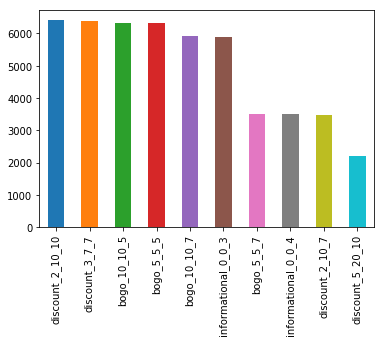

In [283]:
offer_viewed_df.offer_name.value_counts().plot.bar()

In [284]:
#Creating the offer_completed_df
offer_completed_df = offers_detailed.loc[offers_detailed['event'] == 'offer completed']
print(offer_completed_df.shape)
offer_completed_df.head(2)

(32070, 21)


,event,person,time,offer_id,age,gender,income,year_of_membership,membership_class,income_band,...,offer_name,offer_type,reward,difficulty,duration,duration_in_hours,email,mobile,social,web
22661,offer completed,0009655768c64bdeb2e877511632db8f,414,f19421c1d4aa40978ebb69ca19b0e20d,33,M,72000.0,2017,Silver,Upper-middle,...,bogo_5_5_5,bogo,5,5,5,120,1,1,1,1
22665,offer completed,0020ccbbb6d84e358d3414a3ff76cffd,378,f19421c1d4aa40978ebb69ca19b0e20d,24,F,60000.0,2016,Gold,Low-middle,...,bogo_5_5_5,bogo,5,5,5,120,1,1,1,1


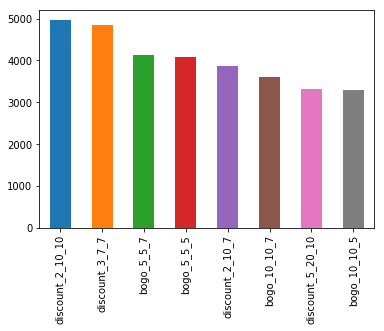

In [285]:
offer_completed_df.offer_name.value_counts().plot.bar()

### Note on informational offers

From the dataframes above we can see that informational offers (i.e., informational_0_0_3 and informational_0_0_4) do not have the 'offer completed' event. They only have the offer received and offer viewed events.

This makes sense as the offer completed event is associated to a person actually transacting to the value of the offer difficulty and since informational offers do not have a monetary difficulty it makes sense that they cannot be 'completed'

### Which customer archetype is most / least views an offer type by offer type

- Age: Youth, Early adulthood, Early Middle Age, Middle Age, Late Middle Age, Senior
- Income: Low, Low-middle, Upper-middle, High
- Membership class: Bronze, Silver, Gold, Platinum, Diamond
- Gender: M, F, O

In [286]:
#test_3 = test_1.iloc[test_1.index.get_level_values('offer_name') == 'informational_0_0_4'].sort_values(by='calc', ascending=False).head(1)

In [287]:
#Step 0
def get_offers(df=portfolio):
    '''
    INPUT:
    df - dataframe with offers
    
    OUTPUT:
    offers - list of all offers
    '''
    all_offers = list(df.offer_name.unique())
    return all_offers    

In [288]:
#Step 1
def get_views_ranked_by_category(category):
    '''
    INPUT:
    category - name of the category to rank offer views by
    
    OUTPUT:
    ranking df - dataframe with ranked offer views by the category
    '''
    for offer in get_offers():
        ranking_df = pd.DataFrame(offers_detailed[offers_detailed['event'] == 'offer received'].groupby(['offer_name', category])['event'].count())
        
        ranking_df['viewed_count'] = offers_detailed[offers_detailed['event'] == 'offer viewed'].groupby(['offer_name', category])['event'].count()
        
        ranking_df['perc_viewed'] = ((ranking_df.viewed_count/ranking_df.event)*100).round(2)
        
        ranking_df = ranking_df.sort_values(by=['offer_name','perc_viewed'], ascending=False)
        
    return ranking_df

In [289]:
#Step 2
def top_ranked_archetypes(df):
    '''
    INPUT:
    df - dataframe of ranked offer views by category
    
    OUTPUT:
    top_ranked_unstacked_df - a dataframe of only the top ranked categories for each offer    
    '''
    top_ranked_df = df.groupby(level=0).head(1)
    top_ranked_unstacked_df = pd.DataFrame(top_ranked_df.to_records())
    
    top_ranked_unstacked_df.plot.bar(x='offer_name', title = 'offer views by '+ top_ranked_unstacked_df.columns[1])
    
    return top_ranked_unstacked_df


In [290]:
#test_z.index[0][0]

In [291]:
#Step 3
def names_only_archetypes(df):
    '''
    INPUT:
    df - a dataframe of only the top ranked category archetype for each offer
    
    OUTPUT:
    df - a dataframe of only the top ranked category archetypes for each offer without the columns for the numbers
    '''
    names_only_ranked_df = pd.DataFrame(df.to_records()).iloc[:, :3]
    
    return names_only_ranked_df

In [292]:
#Step 4
def merge_dataframes(df_1, df_2, df_3, df_4, col_name):
    '''
    INPUT:
    df_1, df_2, df_3, df_4 - for dataframes with a common row to merge on
    'col_name' - common column name
    
    OUTPUT:
    viewed_offers_merged_df - one dataframe consisting of the 4 merged dataframes    
    '''
    temp_df = pd.merge(pd.merge(df_1, df_2, on=col_name), df_3, on=col_name)
    
    viewed_offers_merged_df = pd.merge(temp_df, df_4, on=col_name)
    
    try:
        viewed_offers_merged_df = viewed_offers_merged_df.drop(['index_x', 'index_y'], axis=1)
    except KeyError:
        pass
    
    return viewed_offers_merged_df

In [293]:
#test_y.iloc[test_y.index.get_level_values('offer_name') == 'informational_0_0_4'].sort_values(by='perc_viewed', ascending=False).head(1)

In [294]:
#Step 5
def top_view_archetypes():
    '''
    Print the top profile archetypes that viewed an offer type
    '''
    for offer in offers_viewed_merged_df.offer_name:
        print('The top profile archetypes that viewed the "{}" offer have the following attributes: '.format(offer))
        print('gender: {}'.format(str(list(offers_viewed_merged_df[offers_viewed_merged_df['offer_name'] == offer]['gender'])[0])))
        print('age_band: {}'.format(str(list(offers_viewed_merged_df[offers_viewed_merged_df['offer_name'] == offer]['age_band'])[0])))
        print('income_band: {}, and'.format(str(list(offers_viewed_merged_df[offers_viewed_merged_df['offer_name'] == offer]['income_band'])[0])))
        print('membership_class: {}.'.format(str(list(offers_viewed_merged_df[offers_viewed_merged_df['offer_name'] == offer]['membership_class'])[0])))
        print('\n')

In [295]:
#step 6
def find_archetype_profiles(offer):
    '''
    INPUT:
    offer - the offer name
    
    OUTPUT:
    number of profiles in dataset matching ALL the top_view_archetypes per offer
    List of profile id's in dataset matching ALL the top_view_archetypes per offer
    
    '''
    offers_viewed_subset_df = offers_viewed_merged_df[offers_viewed_merged_df['offer_name'] == offer]
    offer_df = pd.DataFrame(profile[(profile['gender'] == list(offers_viewed_subset_df.gender)[0]) & 
                                           (profile['age_band'] == list(offers_viewed_subset_df.age_band)[0]) & 
                                           (profile['income_band'] == list(offers_viewed_subset_df.income_band)[0]) & 
                                           (profile['membership_class'] == list(offers_viewed_subset_df.membership_class)[0])])
    best_archetypes = list(offer_df.id)
    best_archetypes_count = len(best_archetypes)
    
    return best_archetypes_count, best_archetypes

In [296]:
#Step 7
#Columns testing
def get_event_per_user(event_df):
    '''
    INPUT:
    event_df - a dataframe for an offer event, e.g. - offer_received_df, offer_viewed_df
    
    OUTPUT:
    clean_event_df - a dataframe of the first offer a person received for each offer type. For a person that received multiple offers of the same type we are taking only the first offer
    
    '''
    event_df = event_df.sort_values(by='time', ascending=True).drop_duplicates(subset=['offer_id','person'], keep='first')
    #event_df_pivot = pd.pivot_table(event_df, values='time', index=['offer_name', 'person'], columns=['event'])
    #clean_event_df = pd.DataFrame(event_df_pivot.to_records())
    
    clean_event_df = pd.DataFrame(event_df.groupby(['offer_name', 'person','gender', 'event', 'offer_id', 'age', 'membership_class', 'income_band', 'age_band', 'offer_type', 'duration_in_hours'])['time'].max())
    clean_event_df = pd.DataFrame(clean_event_df.to_records())
    
    return clean_event_df

In [297]:
#Step 8
def merge_on_two_columns(df_1, df_2, df_3, col_1, col_2):
    '''
    INPUT:
    df_1, df_2, df_3 - for dataframes of the offers per profile per event
    col1 - string of the first column to merge on
    col2 - string of the second column to merge on
    
    OUTPUT:
    merged_df - one dataframe consisting of the 3 merged dataframes    
    '''
    offer_events_merged = pd.merge(pd.merge(df_1, df_2, on=[col_1, col_2]), df_3, on=[col_1, col_2])
    
    return offer_events_merged

In [298]:
#Step 9
#Get users who completed without viewing
def get_completed_without_viewing(offer):
    '''
    INPUT:
    offer - name of the offer
    
    OUTPUT:
    completed_without_viewing - list of users who completed the offer without viewing the offer
    
    '''
    a = set(offer_completed_events[offer_completed_events['offer_name'] == offer]['person'])
    b = set(offer_viewed_events[offer_viewed_events['offer_name'] == offer]['person'])
    
    completed_without_viewing = list(a-b)
    
    print(len(completed_without_viewing))
    
    return completed_without_viewing

### gender
Classify views for each offer by gender

In [299]:
#Step 1
ranked_gender_df = get_views_ranked_by_category('gender')

In [300]:
ranked_gender_df

event  viewed_count  perc_viewed
offer_name          gender                                  
informational_0_0_4 F        2797          1551        55.45
                    M        3860          1936        50.16
informational_0_0_3 M        3805          3433        90.22
                    F        2838          2440        85.98
discount_5_20_10    F        2849          1010        35.45
                    M        3877          1205        31.08
discount_3_7_7      F        2773          2669        96.25
                    M        3882          3710        95.57
discount_2_10_7     F        2775          1562        56.29
                    M        3856          1898        49.22
discount_2_10_10    F        2738          2650        96.79
                    M        3914          3757        95.99
bogo_5_5_7          F        2819          1583        56.15
                    M        3866          1916        49.56
bogo_5_5_5          F        2760          2650        96.01
                    M        3816          3660        95.91
bogo_10_10_7        M        3885          3498        90.04
                    F        2798          2403        85.88
bogo_10_10_5        M        3826          3676        96.08
                    F        2767          2653        95.88

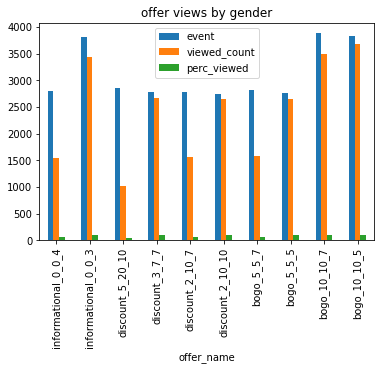

In [301]:
#Step 2
top_ranked_gender_unstacked_df = top_ranked_archetypes(ranked_gender_df)

In [302]:
top_ranked_gender_unstacked_df

,offer_name,gender,event,viewed_count,perc_viewed
0,informational_0_0_4,F,2797,1551,55.45
1,informational_0_0_3,M,3805,3433,90.22
2,discount_5_20_10,F,2849,1010,35.45
3,discount_3_7_7,F,2773,2669,96.25
4,discount_2_10_7,F,2775,1562,56.29
5,discount_2_10_10,F,2738,2650,96.79
6,bogo_5_5_7,F,2819,1583,56.15
7,bogo_5_5_5,F,2760,2650,96.01
8,bogo_10_10_7,M,3885,3498,90.04
9,bogo_10_10_5,M,3826,3676,96.08


In [303]:
#Step 3
names_only_gender_ranked_df = names_only_archetypes(top_ranked_gender_unstacked_df)

In [304]:
names_only_gender_ranked_df

,index,offer_name,gender
0,0,informational_0_0_4,F
1,1,informational_0_0_3,M
2,2,discount_5_20_10,F
3,3,discount_3_7_7,F
4,4,discount_2_10_7,F
5,5,discount_2_10_10,F
6,6,bogo_5_5_7,F
7,7,bogo_5_5_5,F
8,8,bogo_10_10_7,M
9,9,bogo_10_10_5,M


### age_band
Classify offer views by age_band

In [305]:
#Step 1
ranked_age_band_df = get_views_ranked_by_category('age_band')

In [306]:
ranked_age_band_df

event  viewed_count  perc_viewed
offer_name          age_band                                          
informational_0_0_4 Early Middle Age    881           511        58.00
                    Middle Age         1289           743        57.64
                    Senior             1685           918        54.48
                    Late Middle Age    1506           816        54.18
                    Youth               659           281        42.64
                    Early Adulthood     637           218        34.22
informational_0_0_3 Youth               685           652        95.18
                    Early Adulthood     571           536        93.87
                    Early Middle Age    879           820        93.29
                    Middle Age         1344          1179        87.72
                    Late Middle Age    1490          1267        85.03
                    Senior             1674          1419        84.77
discount_5_20_10    Late Middle Age    1554           586        37.71
                    Early Middle Age    893           335        37.51
                    Middle Age         1337           484        36.20
                    Senior             1663           568        34.16
                    Youth               654           142        21.71
                    Early Adulthood     625           100        16.00
discount_3_7_7      Early Middle Age    908           877        96.59
                    Middle Age         1232          1190        96.59
                    Senior             1688          1621        96.03
                    Early Adulthood     618           590        95.47
                    Late Middle Age    1517          1448        95.45
                    Youth               692           653        94.36
discount_2_10_7     Early Middle Age    870           499        57.36
                    Late Middle Age    1520           864        56.84
                    Middle Age         1292           715        55.34
                    Senior             1632           889        54.47
                    Youth               700           276        39.43
                    Early Adulthood     617           217        35.17
discount_2_10_10    Senior             1636          1585        96.88
                    Late Middle Age    1556          1504        96.66
                    Middle Age         1282          1235        96.33
                    Early Middle Age    858           826        96.27
                    Early Adulthood     655           629        96.03
                    Youth               665           628        94.44
bogo_5_5_7          Early Middle Age    897           529        58.97
                    Middle Age         1358           775        57.07
                    Senior             1670           896        53.65
                    Late Middle Age    1493           799        53.52
                    Youth               650           269        41.38
                    Early Adulthood     617           231        37.44
bogo_5_5_5          Middle Age         1308          1265        96.71
                    Late Middle Age    1487          1432        96.30
                    Early Middle Age    869           836        96.20
                    Senior             1653          1578        95.46
                    Early Adulthood     591           563        95.26
                    Youth               668           636        95.21
bogo_10_10_7        Early Adulthood     638           614        96.24
                    Youth               669           631        94.32
                    Early Middle Age    922           856        92.84
                    Senior             1611          1404        87.15
                    Middle Age         1296          1110        85.65
                    Late Middle Age    1547          1286        83.13
bogo_10_10_5        Early Middle Age    851           828     

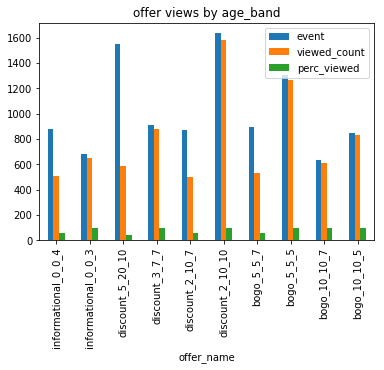

In [307]:
#Step 2
top_ranked_age_band_unstacked_df = top_ranked_archetypes(ranked_age_band_df)

In [308]:
top_ranked_age_band_unstacked_df

,offer_name,age_band,event,viewed_count,perc_viewed
0,informational_0_0_4,Early Middle Age,881,511,58.00
1,informational_0_0_3,Youth,685,652,95.18
2,discount_5_20_10,Late Middle Age,1554,586,37.71
3,discount_3_7_7,Early Middle Age,908,877,96.59
4,discount_2_10_7,Early Middle Age,870,499,57.36
5,discount_2_10_10,Senior,1636,1585,96.88
6,bogo_5_5_7,Early Middle Age,897,529,58.97
7,bogo_5_5_5,Middle Age,1308,1265,96.71
8,bogo_10_10_7,Early Adulthood,638,614,96.24
9,bogo_10_10_5,Early Middle Age,851,828,97.30


In [309]:
#Step 3
names_only_age_band_ranked_df = names_only_archetypes(top_ranked_age_band_unstacked_df)

In [310]:
names_only_age_band_ranked_df

,index,offer_name,age_band
0,0,informational_0_0_4,Early Middle Age
1,1,informational_0_0_3,Youth
2,2,discount_5_20_10,Late Middle Age
3,3,discount_3_7_7,Early Middle Age
4,4,discount_2_10_7,Early Middle Age
5,5,discount_2_10_10,Senior
6,6,bogo_5_5_7,Early Middle Age
7,7,bogo_5_5_5,Middle Age
8,8,bogo_10_10_7,Early Adulthood
9,9,bogo_10_10_5,Early Middle Age


### income_band

Classify offer views by age_band

In [311]:
#Step 1
ranked_income_band_df = get_views_ranked_by_category('income_band')

In [312]:
ranked_income_band_df

event  viewed_count  perc_viewed
offer_name          income_band                                   
informational_0_0_4 Upper-middle   1644          1002        60.95
                    High           1554           937        60.30
                    Low-middle     1782          1005        56.40
                    Low            1677           543        32.38
informational_0_0_3 Low            1672          1589        95.04
                    Low-middle     1789          1663        92.96
                    Upper-middle   1553          1360        87.57
                    High           1629          1261        77.41
discount_5_20_10    High           1600           669        41.81
                    Low-middle     1709           650        38.03
                    Upper-middle   1658           621        37.45
                    Low            1759           275        15.63
discount_3_7_7      Low-middle     1751          1690        96.52
                    Upper-middle   1627          1565        96.19
                    High           1582          1520        96.08
                    Low            1695          1604        94.63
discount_2_10_7     High           1583           973        61.47
                    Low-middle     1719          1009        58.70
                    Upper-middle   1632           923        56.56
                    Low            1697           555        32.70
discount_2_10_10    Upper-middle   1651          1601        96.97
                    Low-middle     1742          1688        96.90
                    High           1573          1518        96.50
                    Low            1686          1600        94.90
bogo_5_5_7          High           1618           945        58.41
                    Upper-middle   1600           931        58.19
                    Low-middle     1717           982        57.19
                    Low            1750           641        36.63
bogo_5_5_5          Low-middle     1749          1694        96.86
                    Upper-middle   1579          1522        96.39
                    High           1603          1543        96.26
                    Low            1645          1551        94.29
bogo_10_10_7        Low            1702          1627        95.59
                    Low-middle     1725          1591        92.23
                    Upper-middle   1600          1392        87.00
                    High           1656          1291        77.96
bogo_10_10_5        Upper-middle   1660          1604        96.63
                    Low-middle     1686          1622        96.20
                    High           1563          1499        95.91
                    Low            1684          1604        95.25

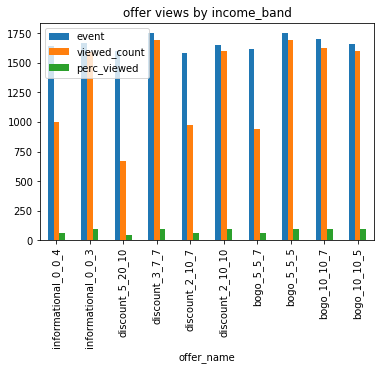

In [313]:
#Step 2
top_ranked_income_band_unstacked_df = top_ranked_archetypes(ranked_income_band_df)

In [314]:
top_ranked_income_band_unstacked_df

,offer_name,income_band,event,viewed_count,perc_viewed
0,informational_0_0_4,Upper-middle,1644,1002,60.95
1,informational_0_0_3,Low,1672,1589,95.04
2,discount_5_20_10,High,1600,669,41.81
3,discount_3_7_7,Low-middle,1751,1690,96.52
4,discount_2_10_7,High,1583,973,61.47
5,discount_2_10_10,Upper-middle,1651,1601,96.97
6,bogo_5_5_7,High,1618,945,58.41
7,bogo_5_5_5,Low-middle,1749,1694,96.86
8,bogo_10_10_7,Low,1702,1627,95.59
9,bogo_10_10_5,Upper-middle,1660,1604,96.63


In [315]:
#Step 3
names_only_income_band_ranked_df = names_only_archetypes(top_ranked_income_band_unstacked_df)

In [316]:
names_only_income_band_ranked_df

,index,offer_name,income_band
0,0,informational_0_0_4,Upper-middle
1,1,informational_0_0_3,Low
2,2,discount_5_20_10,High
3,3,discount_3_7_7,Low-middle
4,4,discount_2_10_7,High
5,5,discount_2_10_10,Upper-middle
6,6,bogo_5_5_7,High
7,7,bogo_5_5_5,Low-middle
8,8,bogo_10_10_7,Low
9,9,bogo_10_10_5,Upper-middle


### membership_class

Classify offer views by membership_class

In [317]:
#Step 1
ranked_membership_class_df = get_views_ranked_by_category('membership_class')

In [318]:
ranked_membership_class_df

event  viewed_count  perc_viewed
offer_name          membership_class                                  
informational_0_0_4 Platinum            699           400        57.22
                    Gold               1345           755        56.13
                    Diamond             439           240        54.67
                    Silver             2521          1313        52.08
                    Bronze             1653           779        47.13
informational_0_0_3 Diamond             407           366        89.93
                    Bronze             1595          1424        89.28
                    Silver             2570          2285        88.91
                    Gold               1368          1190        86.99
                    Platinum            703           608        86.49
discount_5_20_10    Gold               1383           506        36.59
                    Silver             2475           812        32.81
                    Bronze             1705           555        32.55
                    Platinum            740           229        30.95
                    Diamond             423           113        26.71
discount_3_7_7      Gold               1351          1305        96.60
                    Silver             2544          2449        96.27
                    Bronze             1691          1619        95.74
                    Diamond             416           392        94.23
                    Platinum            653           614        94.03
discount_2_10_7     Diamond             405           236        58.27
                    Gold               1357           776        57.18
                    Platinum            738           410        55.56
                    Silver             2470          1262        51.09
                    Bronze             1661           776        46.72
discount_2_10_10    Gold               1349          1310        97.11
                    Platinum            724           698        96.41
                    Silver             2429          2338        96.25
                    Diamond             442           424        95.93
                    Bronze             1708          1637        95.84
bogo_5_5_7          Platinum            786           460        58.52
                    Diamond             414           225        54.35
                    Gold               1347           729        54.12
                    Silver             2512          1266        50.40
                    Bronze             1626           819        50.37
bogo_5_5_5          Diamond             398           387        97.24
                    Gold               1328          1282        96.54
                    Platinum            679           653        96.17
                    Silver             2553          2449        95.93
                    Bronze             1618          1539        95.12
bogo_10_10_7        Bronze             1668          1494        89.57
                    Diamond             422           377        89.34
                    Silver             2491          2199        88.28
                    Platinum            731           639        87.41
                    Gold               1371          1192        86.94
bogo_10_10_5        Bronze             1582          1532        96.84
                    Gold               1321          1274        96.44
                    Silver             2560          2446        95.55
                    Platinum            697           665        95.41
                    Diamond             433           412        95.15

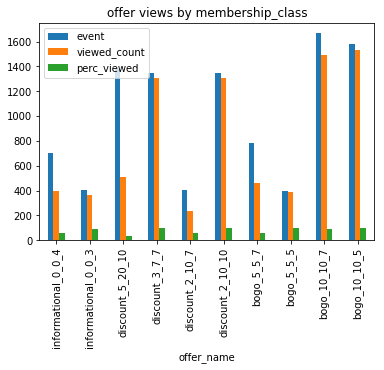

In [319]:
#Step 2
top_ranked_membership_class_unstacked_df = top_ranked_archetypes(ranked_membership_class_df)

In [320]:
top_ranked_membership_class_unstacked_df

,offer_name,membership_class,event,viewed_count,perc_viewed
0,informational_0_0_4,Platinum,699,400,57.22
1,informational_0_0_3,Diamond,407,366,89.93
2,discount_5_20_10,Gold,1383,506,36.59
3,discount_3_7_7,Gold,1351,1305,96.60
4,discount_2_10_7,Diamond,405,236,58.27
5,discount_2_10_10,Gold,1349,1310,97.11
6,bogo_5_5_7,Platinum,786,460,58.52
7,bogo_5_5_5,Diamond,398,387,97.24
8,bogo_10_10_7,Bronze,1668,1494,89.57
9,bogo_10_10_5,Bronze,1582,1532,96.84


In [321]:
#Step 3
names_only_membership_class_ranked_df = names_only_archetypes(top_ranked_membership_class_unstacked_df)

In [322]:
names_only_membership_class_ranked_df

,index,offer_name,membership_class
0,0,informational_0_0_4,Platinum
1,1,informational_0_0_3,Diamond
2,2,discount_5_20_10,Gold
3,3,discount_3_7_7,Gold
4,4,discount_2_10_7,Diamond
5,5,discount_2_10_10,Gold
6,6,bogo_5_5_7,Platinum
7,7,bogo_5_5_5,Diamond
8,8,bogo_10_10_7,Bronze
9,9,bogo_10_10_5,Bronze


Now I will merge all the four dataframes into one dataframe with the top ranked category archetype that viewed an offer

In [323]:
#Step 4
offers_viewed_merged_df = merge_dataframes(names_only_gender_ranked_df, names_only_age_band_ranked_df, names_only_income_band_ranked_df, names_only_membership_class_ranked_df, 'offer_name')

In [324]:
offers_viewed_merged_df

,offer_name,gender,age_band,income_band,membership_class
0,informational_0_0_4,F,Early Middle Age,Upper-middle,Platinum
1,informational_0_0_3,M,Youth,Low,Diamond
2,discount_5_20_10,F,Late Middle Age,High,Gold
3,discount_3_7_7,F,Early Middle Age,Low-middle,Gold
4,discount_2_10_7,F,Early Middle Age,High,Diamond
5,discount_2_10_10,F,Senior,Upper-middle,Gold
6,bogo_5_5_7,F,Early Middle Age,High,Platinum
7,bogo_5_5_5,F,Middle Age,Low-middle,Diamond
8,bogo_10_10_7,M,Early Adulthood,Low,Bronze
9,bogo_10_10_5,M,Early Middle Age,Upper-middle,Bronze


Get the list of the top archetypes that viewed an offer per each classification category

In [325]:
#Step 5
top_view_archetypes()

The top profile archetypes that viewed the "informational_0_0_4" offer have the following attributes: 
gender: F
age_band: Early Middle Age
income_band: Upper-middle, and
membership_class: Platinum.


The top profile archetypes that viewed the "informational_0_0_3" offer have the following attributes: 
gender: M
age_band: Youth
income_band: Low, and
membership_class: Diamond.


The top profile archetypes that viewed the "discount_5_20_10" offer have the following attributes: 
gender: F
age_band: Late Middle Age
income_band: High, and
membership_class: Gold.


The top profile archetypes that viewed the "discount_3_7_7" offer have the following attributes: 
gender: F
age_band: Early Middle Age
income_band: Low-middle, and
membership_class: Gold.


The top profile archetypes that viewed the "discount_2_10_7" offer have the following attributes: 
gender: F
age_band: Early Middle Age
income_band: High, and
membership_class: Diamond.


The top profile archetypes that viewed the "discount_2_1

- Get the count of profiles that match exactly ALL the archetypes that viewed an offer
- Get the list of profiles that match exactly ALL the archetypes that viewed an offer

In [326]:
#Step 6
#Get count and list of profile exactly matching ALL the archetypes that viewed an offer
find_archetype_profiles("informational_0_0_4")

(15,
 ['fcd99b61afe74be29d9b3826109b868a',
  'c0a71ad1634e4a2e8468deae1acb09bb',
  '1c284a07aef445cba96d097daae3ec75',
  '8628ceaae12a465f8172aff1071a4438',
  'ff9f73ead16a4f9b9e1a53a27280af92',
  'a24c620e16fd46b19f67ad6ca0a73dde',
  '91ccf5dc4998403e94205f194efd95e0',
  'de0e17b726dc49e793471ec8b6b08b3e',
  '189bdb80e3174d7c8de4d554ef37acb4',
  '06609f295aba4e42abdaf07c2f758303',
  'f3546c329bc94299a5ac043842df9374',
  '8c7d4817ae3a4f2f8fa57c533921f02e',
  'e4ebf2c6fb654838be483f43c6e31b82',
  '239f99fbeec1414482a02223af0e9702',
  'a5b421b4863d499092959fce048cb9c4'])

In [327]:
#Step 6
#Get count and list of profile exactly matching ALL the archetypes that viewed an offer
find_archetype_profiles('informational_0_0_3')

(45,
 ['576e6eed3c6a4ac682ebd35b7ea672f4',
  'e2bf690856ee49bab84b794581636d0d',
  'c0ec94b876144b3ab6605ff6e9527564',
  '316f9251e7564cc095ba1654556b9315',
  '3a87f570d4d643c5bac694b2a830d252',
  'd4fa96bdf9c94098afaa05cfbeba1958',
  '5fa8b71b28e1485d9d3fc1368c469bcd',
  'd12f8c848c854a9ebf3443457e172e01',
  'ff7cc9b97c7744cfbc31bb020ea8d07e',
  'ba3395366d96453981bc7a738ebc2ead',
  '714074e087534d908f4ca450f4efa52a',
  'bb272cd4cac24fcc8f0168cfb5c6f063',
  'b008527a63914a51bf97fc0b800e7fe1',
  'f08366a9813843d2affd5f79164c2669',
  '637b71c75f1444e38e2e361746590e5a',
  '6d93d0f88895420d8dfdca9ff5390bce',
  '3dfb16c7592048699d72aba5307fc67d',
  '85ba195ec59d433e81b89e72803b11b0',
  '86a612903b4b4b3f982eeae088dee3cb',
  '74baf5c00ec246b19efd321ce3873352',
  '586f34cfc4ac462bb6d87026c7bc3aad',
  'e26c4547c87543e8a3b01dd13165b807',
  '49cef4f5a3e642579a8633f87645794b',
  'e7f6dc2a3bb7493ca35cebbbe6e444bb',
  '5cd966bc5ef04cb6b3aaad696d06444f',
  '94b10e52b5b246c791cf2bd310e88cc9',
  '3e4e

In [328]:
#Step 6
#Get count and list of profile exactly matching ALL the archetypes that viewed an offer
find_archetype_profiles('discount_5_20_10')

(207,
 ['791ffe6d3dc848d2b233129a8096f7ab',
  '73c157a4b8e342fcb5d8479d8cb41e81',
  'aec532a91d9948cb828cc657fa27fce2',
  'b7658a8eab2f42668a9d66499b001e88',
  '7da4476ec7234c0fa8f05d2336669212',
  'd11e7279219b418eb0133758d88ee285',
  '5979ee1e3e744c98afd9f72d9be32546',
  'ec290c4f5c204a4c85f256ee190bd583',
  '309e6ef35e8746ec9031a781304bd5cd',
  '0091d2b6a5ea4defaa8393e4e816db60',
  'df3da7cfcf614b3481b65c89657994ed',
  '3938125799fc4ebca4d77ca64701926e',
  '1792e4aafac94412ae1cd299353c8e15',
  '2481f1fcfbcb4b288e5a03af02d95373',
  'bd7b13b7520b4bd1aed39c026ebb9116',
  '4fa5fba731c94e74918af175bf6f6bac',
  '72f6338d8b124f06be857d656019e0f8',
  '56630668a08842a38f32bf4f7bfa4125',
  '147be99d763240b4b7cbe0e024693807',
  'cd548ef6e88b4b78844ead60c8c628c5',
  '690ce015f65549f693d69593f3bd4663',
  'e309916d14da4d85838e81462faee824',
  'abf29a94ba3d4648869ad7505d863e22',
  '80242cc3d985484fbeeeb7d3cf828b71',
  '40add65eeccb484eb5567ac2c81601f2',
  '2e40baf0355a41329025e8da10bc7c54',
  '526

In [329]:
#Step 6
#Get count and list of profile exactly matching ALL the archetypes that viewed an offer
find_archetype_profiles('discount_3_7_7')

(48,
 ['93c230e2ff31416c9fc190cd560f8653',
  '533342f427824eb59adc4aa9949fe666',
  'b13775803ef54a42970428c05b9f3dfb',
  '2449f2f011d24c849f72b15303f89f4b',
  'ffff82501cea40309d5fdd7edcca4a07',
  '43ba16ae14404ada9c749043c66f3741',
  'ff3bc5e639a145fab9b8fe1df14349a6',
  '9e473f9bd189408c8fcbb000822f59e6',
  '04ca4f4a66934cec9d3bbd8833572cf7',
  'd41708667be04a42a02a9c4ec673765d',
  'a7d1c458a2844d138ecd7f2b189c22fe',
  '1042af9d04334a29beb957a03a850b9e',
  '569ae3091eaa4c0c8378680dbff44d71',
  'c7c7c87a97a04536b8c7f5a5e386935a',
  '0ae565c6ebc5417db7f6d2ee5eaabe72',
  'c68cee330a1b43b38c15b352a72215a6',
  'b25c8057261c43389f7ecb7df164b034',
  'f969f5f7c6964961ae6c27bd366d51b6',
  'f5234309a757421aadc37da0e69dfdbb',
  'ec894ba87ade4d5d8a980e0b51c7fcd0',
  'a83c48c17c2a45daa51345d5fa6a0a7a',
  '9c7eedb7b2a340c39abe071aabaee8af',
  '8121823454154aca8766a4753fe0c26d',
  'd0ab05be7544435f935f13082b31ff0e',
  'c351f19547574c92a69d01bca7d7ad6e',
  '834dede1a06246598ffddc82d4ef02e9',
  '627a

In [330]:
#Step 6
#Get count and list of profile exactly matching ALL the archetypes that viewed an offer
find_archetype_profiles('discount_2_10_7')

(4,
 ['591b17b5a24a44f7a23bd2296e46e0c4',
  'cff9e1e91e924e7680871a835b06400c',
  '102f765955ad4c28b922dc7858729f16',
  '22fb7286392241b5a8c92be7a23a04a9'])

In [331]:
#Step 6
#Get count and list of profile exactly matching ALL the archetypes that viewed an offer
find_archetype_profiles('discount_2_10_10')

(111,
 ['5cd6577aca5d4b419e452f9f505ffce7',
  'f8aedd0cbea0419c806842b4265b82e5',
  '78e9be059fce46a1b610f74e0e812a4a',
  '50fb5c0c6b1b4f43bd5f4a818dddb513',
  'b463e46aa28748849542d6f24d775240',
  'ac45ea89ce2a4cbbac7ec267c9226482',
  '605799ea4d6541a2894e39e9498cdaa6',
  'aeea18cf2e8d455c98453c546292a9f6',
  '26c210f0e0c249f597a2a5663d4fead2',
  'c64705baf7b04473b0c4ed043e6889fc',
  '469227d170274de18bf33e6bebe8bcd0',
  '17dddcba2e9443bb97cafb78f51ebdbe',
  'a53cf0dc906c47e8bad3db0618953584',
  '27920c5d12634b278ff089b05772f013',
  '119883e8c6b04528a91360e82d4f07c6',
  '2f6623e657b24825a063f8e0ec8e368a',
  '8957e167deef47f1aa157fb7a9891379',
  '375b452ee0b64a4fbac92e61670f961d',
  'ae1c83d44e834751ab329f9dc241c951',
  'e6d73832444a429aaa969b706a5a2bf1',
  'ce1579c557c14f7785869dc80638bc0f',
  'c2b04827cfc1449abeaa606bdc057115',
  '552d9d2c23f34ce8bf2f352378b4ca46',
  '294d70ffce184eefaf78cda29870d280',
  '455a7c0dc2cc41b1a30c8722fc8b4c39',
  '2bb9ae13afd749f6bcfd45b95430b02a',
  'f27

In [332]:
#Step 6
#Get count and list of profile exactly matching ALL the archetypes that viewed an offer
find_archetype_profiles('bogo_5_5_7')

(15,
 ['f5e705aa4a81404abe294559f1904fb7',
  '5d5a65281fea4922aba7fbc22dcf4f4b',
  'd7dd26d7142d4e51b63770cf9db2f91f',
  '464fcd7b30524d6d9e94c6cabcd106e1',
  '906a503983444d939dbb4c97e34ba9d2',
  'e6883e7ddd874cfdbf8fe14152859e78',
  'a75203da0a9b45dc968320ae331272c4',
  '035d5aa3c23a4059ae663b4c07aa26ce',
  'cc8812db238a4bb9962dbef576925c5b',
  'd3e15aa9c2a74610aad1c4f87aab44c7',
  '878a89abc3bd43a8841629c4e84187aa',
  '3396faea6acd42538d1ab5f76ba1a942',
  '2520c1ca400d43f4bf52ed6f482a6a75',
  '7106e78bb41f4e5fab74c2c9cf1e459f',
  '7103a340ed8244e1bee58a9639b7678b'])

In [333]:
#Step 6
#Get count and list of profile exactly matching ALL the archetypes that viewed an offer
find_archetype_profiles('bogo_5_5_5')

(12,
 ['21eef0356f42406c9e70c5e1c03ab378',
  '9a0e465c898540a9b6221a6ddca88f60',
  '7159a65a128b4e63b2e708b119414195',
  'dcdb89c01fb24f26a22cba4b95098d79',
  '5ee1d22dc9884df8bdf38171a69095d1',
  '6280ae4ee7844024bbcdb9d339d2d859',
  '61e51bc52f4d4c8b930db40be1cdd083',
  '67a480913cbf4cd08093889b545181c3',
  'deb2b76714a74d8a98caf51374227419',
  '3193b8e2bafd48859069d1ec891ff92a',
  'b6aa40b2d89c487aa5ccf9029ecbaea4',
  'c29c5989f2dd444080daae5a0f6db71a'])

In [334]:
#Step 6
#Get count and list of profile exactly matching ALL the archetypes that viewed an offer
find_archetype_profiles('bogo_10_10_7')

(129,
 ['6e04a90a0e074496b5f229eb1f553433',
  '4c2a9b684dde4658b71073d1432fac91',
  'bafc2350ece84692b0db74a6130a213c',
  '1418e71469474b7fa160cd76b198cb08',
  '938d98afcb894aeb8db9c60fca96ec58',
  '72c31f4851d14c85aef4fe06f9c13c4a',
  '88a5c73f15144c5fae93006b818adb79',
  '4d7d5a156adf4aa4b4a1f5b8851d1e7a',
  '5a7af629a0244c35b98846d4fc8d4603',
  '36d5a70069e04c0b80bdb2feec41a2db',
  '267e47de94fd46b1afa96dea1c9d3cbf',
  '30fadd9896cf48c6ace28bd1e88e172f',
  '559082c5907547069a80e23d8cfc7c35',
  'ab19930f782f437a999bd981404c1e5d',
  'dba0582e295e4cb48263751157e4e821',
  'c5fffd0bbfeb4063bddc66c85481931b',
  '980042c1e18f4d0e97f169b1c4db22a2',
  '9aa6316728c24a16a7819ba6cefb6060',
  '019cc78d8fed432ca6df71c132c72a99',
  '00ceaf16a40341e6996d543d04daa2c2',
  'cd0cb9d1599c47a0bb69c49d19c2117f',
  '4a77318aff504e48837d945af45d6727',
  'bad8cb8365e44604b3d415b78dc77582',
  '5c6c1b8f33b5457893a00b94f5895afb',
  'f1a6b06e6d4e419daa4573bc6196474d',
  'd20b60b322fc464f8bf26593330880c5',
  '66f

In [335]:
#Step 6
#Get count and list of profile exactly matching ALL the archetypes that viewed an offer
find_archetype_profiles('bogo_10_10_5')

(78,
 ['30f768e59835437d86743fd5daad69e3',
  '47eb14d1e8514ffe89fa66e5ee351404',
  '7f872e820d574862bfb79fdb3b2da602',
  'a02bb1e96a9b452cbd38a5a3c250b2c6',
  'b085f625dfab4a6e860e32fadb64bd68',
  '86393faabf374030a53989634fd94933',
  '1037671bee8d419d8bbc2105f4cd00ba',
  '39c275d2c1c346b29bfb3c453740ecc9',
  'a1110e0aaa5a4255bfa8253cab228446',
  'c2c2220c07a348229331b65e356e6602',
  '572a08d7ec2b4947b3cb9ea0d8d0c9a0',
  'b3cca059a8a346cc89fabfe1b7b5ee88',
  '742d4ed2ba5545fdb8dc320020f38cc3',
  '8997d5d133d54e91b320923db642dc42',
  'b070360c5c3d4fec976a188a6972aa08',
  '79258dac19b04f8297d03ffdaf1e80ba',
  'b7ba298aace641d6be40b07ef1305bd7',
  '0a13150de06440bea92ed6aeaadf5b9d',
  '8cad8005c2794346a3b332db58a211e4',
  'e4564aa65a714a7ca782e41c23f20b0d',
  'f1889618c1d6407c855ac642b08b635a',
  'b5416c7b6cc0409eb428aa6f098b4480',
  '549dcda4abdb4803aa423e1d982a5f30',
  '5d02e48e7b974a69875d0c6ab097928e',
  '1d8065fbc9e848f280796c837ed76f81',
  '317a2d6210ac4d019b73372b6269f1f0',
  '0964

In [336]:
offer_received_df.head()

,event,person,time,offer_id,age,gender,income,year_of_membership,membership_class,income_band,...,offer_name,offer_type,reward,difficulty,duration,duration_in_hours,email,mobile,social,web
0,offer received,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,33,M,72000.0,2017,Silver,Upper-middle,...,informational_0_0_3,informational,0,0,3,72,1,1,1,0
2,offer received,0011e0d4e6b944f998e987f904e8c1e5,336,5a8bc65990b245e5a138643cd4eb9837,40,M,57000.0,2018,Bronze,Low-middle,...,informational_0_0_3,informational,0,0,3,72,1,1,1,0
4,offer received,0020c2b971eb4e9188eac86d93036a77,504,5a8bc65990b245e5a138643cd4eb9837,59,F,90000.0,2016,Gold,High,...,informational_0_0_3,informational,0,0,3,72,1,1,1,0
6,offer received,0020ccbbb6d84e358d3414a3ff76cffd,408,5a8bc65990b245e5a138643cd4eb9837,24,F,60000.0,2016,Gold,Low-middle,...,informational_0_0_3,informational,0,0,3,72,1,1,1,0
8,offer received,003d66b6608740288d6cc97a6903f4f0,0,5a8bc65990b245e5a138643cd4eb9837,26,F,73000.0,2017,Silver,Upper-middle,...,informational_0_0_3,informational,0,0,3,72,1,1,1,0


- For each offer type, get the first offer that a person viewed
- For each offer type, get the first offer that a person completed

In [337]:
#Get offers of the first offer a person received for each offer type
offer_received_events = get_event_per_user(offer_received_df)
print(offer_received_events.shape)
offer_received_events.head(3)

(55222, 12)


,offer_name,person,gender,event,offer_id,age,membership_class,income_band,age_band,offer_type,duration_in_hours,time
0,bogo_10_10_5,0020c2b971eb4e9188eac86d93036a77,F,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,59,Gold,High,Late Middle Age,bogo,120,408
1,bogo_10_10_5,00715b6e55c3431cb56ff7307eb19675,F,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,58,Silver,High,Late Middle Age,bogo,120,336
2,bogo_10_10_5,00857b24b13f4fe0ad17b605f00357f5,M,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,71,Silver,Low,Senior,bogo,120,0


In [338]:
#Get the first offer a person viewed for each offer type
offer_viewed_events = get_event_per_user(offer_viewed_df)
print(offer_viewed_events.shape)
offer_viewed_events.head(3)

(42493, 12)


,offer_name,person,gender,event,offer_id,age,membership_class,income_band,age_band,offer_type,duration_in_hours,time
0,bogo_10_10_5,0020c2b971eb4e9188eac86d93036a77,F,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,59,Gold,High,Late Middle Age,bogo,120,426
1,bogo_10_10_5,00857b24b13f4fe0ad17b605f00357f5,M,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,71,Silver,Low,Senior,bogo,120,0
2,bogo_10_10_5,008d7088107b468893889da0ede0df5c,M,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,24,Silver,Low,Youth,bogo,120,558


In [339]:
#Get the first offer a person completed for each offer type
offer_completed_events = get_event_per_user(offer_completed_df)
print(offer_completed_events.shape)
offer_completed_events.head(3)

(27942, 12)


,offer_name,person,gender,event,offer_id,age,membership_class,income_band,age_band,offer_type,duration_in_hours,time
0,bogo_10_10_5,0020c2b971eb4e9188eac86d93036a77,F,offer completed,4d5c57ea9a6940dd891ad53e9dbe8da0,59,Gold,High,Late Middle Age,bogo,120,510
1,bogo_10_10_5,00715b6e55c3431cb56ff7307eb19675,F,offer completed,4d5c57ea9a6940dd891ad53e9dbe8da0,58,Silver,High,Late Middle Age,bogo,120,342
2,bogo_10_10_5,0091d2b6a5ea4defaa8393e4e816db60,F,offer completed,4d5c57ea9a6940dd891ad53e9dbe8da0,62,Gold,High,Late Middle Age,bogo,120,6


For each offer get the list of persons who completed the offer without viewing the offer

In [340]:
#Get the list of persons who completed an offer without viewing the offer
#bogo_10_10_7
completed_without_viewing_bogo_10_10_7 = get_completed_without_viewing("bogo_10_10_7")
completed_without_viewing_bogo_10_10_7[:3]

333


['36e18fa7d9f64956bc84770a085243e3',
 'd448fa911f3f4b4aafe87396d220fad6',
 '0a0bb27cb9904b638d376ad1c6d09e81']

In [341]:
#Get the list of persons who completed an offer without viewing the offer
#bogo_10_10_5
completed_without_viewing_bogo_10_10_5 = get_completed_without_viewing("bogo_10_10_5")
completed_without_viewing_bogo_10_10_5[:3]

60


['91aef7566d8c4965aa29687a05a9ab25',
 'f0d129d6bb79456b8529884a83d16007',
 '9e34cfea6818482197c2a5c397a2e256']

In [342]:
#Get the list of persons who completed an offer without viewing the offer
#informational_0_0_4
completed_without_viewing_informational_0_0_4 = get_completed_without_viewing("informational_0_0_4")
completed_without_viewing_informational_0_0_4[:3]

0


[]

In [343]:
#Get the list of persons who completed an offer without viewing the offer
#bogo_5_5_7
completed_without_viewing_bogo_5_5_7 = get_completed_without_viewing("bogo_5_5_7")
completed_without_viewing_bogo_5_5_7[:3]

1230


['5cfc907778a9457382cf0731819cebe2',
 '84c5b62c4f4c405dbc338315dc07309f',
 '00cf471ed1aa42a8bdde5561d67da2b1']

In [344]:
#Get the list of persons who completed an offer without viewing the offer
#discount_5_20_10
completed_without_viewing_discount_5_20_10 = get_completed_without_viewing("discount_5_20_10")
completed_without_viewing_discount_5_20_10[:3]

1492


['71721bc113e246aea2209b2aa7a5d58f',
 '11b7e48f97cc4237a996e3ca88bc447d',
 'e08f5946ac204395ba4b6168505eccbc']

In [345]:
#Get the list of persons who completed an offer without viewing the offer
#discount_3_7_7
completed_without_viewing_discount_3_7_7 = get_completed_without_viewing("discount_3_7_7")
completed_without_viewing_discount_3_7_7[:3]

105


['2ecc1d321e4241f38124bc703dcdf63e',
 '4957ce23e5594b26a7b374b20271ed47',
 'abd6e8f0ea7d4f0f877e1683213dabb9']

In [346]:
#Get the list of persons who completed an offer without viewing the offer
#discount_2_10_10
completed_without_viewing_discount_2_10_10 = get_completed_without_viewing("discount_2_10_10")
completed_without_viewing_discount_2_10_10[:3]

94


['fb1cc1b009db4a6caf274f2a02571ca2',
 '5a90d3a4a21b4262b75ad9533bdf162b',
 'e1c43b9050494f5e9b51c057d7570a98']

In [347]:
#Get the list of persons who completed an offer without viewing the offer
#informational_0_0_3
completed_without_viewing_informational_0_0_3 = get_completed_without_viewing("informational_0_0_3")
completed_without_viewing_informational_0_0_3[:3]

0


[]

In [348]:
#Get the list of persons who completed an offer without viewing the offer
#bogo_5_5_5
completed_without_viewing_bogo_5_5_5 = get_completed_without_viewing("bogo_5_5_5")
completed_without_viewing_bogo_5_5_5[:3]

81


['b8bef39dd2654f90af97658f0ca65f75',
 '84be43a1f66b4abfa2d57321036e2559',
 '2cec68f40dd4472aaebddeb1308e8a61']

In [349]:
#Get the list of persons who completed an offer without viewing the offer
#discount_2_10_7
completed_without_viewing_discount_2_10_7 = get_completed_without_viewing("discount_2_10_7")
completed_without_viewing_discount_2_10_7[:3]

1048


['04c66db4925042a5bb103fec87225370',
 '85471205af46440093b68bf72f1c2a93',
 '762384c7198a4af8b1773400d8ec0335']

I want to find only records that are common to both dataframes. i.e. a person both viewed and completed an offer. In other words, persons who completed an offer they did not view will be excluded.

In [350]:
#only records that are common to both dataframes
offers_viewed_completed = offer_viewed_events.merge(offer_completed_events, on=['offer_name', 'person', 'gender', 'offer_id', 'age', 'membership_class', 'income_band', 'age_band', 'offer_type', 'duration_in_hours' ], how='inner', indicator=False)
offers_viewed_completed = offers_viewed_completed.rename(columns = {'time_x': 'offer viewed', 'time_y': 'offer completed'})
print(offers_viewed_completed.shape)
offers_viewed_completed

(23499, 14)


,offer_name,person,gender,event_x,offer_id,age,membership_class,income_band,age_band,offer_type,duration_in_hours,offer viewed,event_y,offer completed
0,bogo_10_10_5,0020c2b971eb4e9188eac86d93036a77,F,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,59,Gold,High,Late Middle Age,bogo,120,426,offer completed,510
1,bogo_10_10_5,0091d2b6a5ea4defaa8393e4e816db60,F,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,62,Gold,High,Late Middle Age,bogo,120,6,offer completed,6
2,bogo_10_10_5,00b3c376db2a4115af3aef34a02f61d6,M,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,50,Silver,High,Middle Age,bogo,120,594,offer completed,582
3,bogo_10_10_5,00c20a9202d5475190b31a24de6fb06d,M,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,52,Gold,Upper-middle,Middle Age,bogo,120,576,offer completed,576
4,bogo_10_10_5,00c2f812f4604c8893152a5c6572030e,F,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,58,Bronze,High,Late Middle Age,bogo,120,0,offer completed,582
5,bogo_10_10_5,00d6dc87be4146ceb47fcd4baaaf6477,F,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,58,Silver,High,Late Middle Age,bogo,120,642,offer completed,642
6,bogo_10_10_5,00d791e20c564add8056498e40eb56cc,M,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,22,Platinum,Low,Youth,bogo,120,606,offer completed,582
7,bogo_10_10_5,00d7c95f793a4212af44e632fdc1e431,M,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,71,Gold,Upper-middle,Senior,bogo,120,12,offer completed,84
8,bogo_10_10_5,01380da907f8495496679c795867790b,F,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,86,Silver,Upper-middle,Senior,bogo,120,168,offer completed,216
9,bogo_10_10_5,0157e63b39c5456393026c6c03f3d84a,F,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,70,Silver,Upper-middle,Senior,bogo,120,426,offer completed,432


For the sake of simplicity, I am going to consider that a person that viewed an offer before or at the same time of completing the offer got some influence at least from the offer they viewed. It doesn't matter if they had strated their transaction count before viewing the offer, I am considering that viewing the offer at least gave them a push to transact somemore in order to complete the offer.

So for this analysis the transactions dataframe will not be utilised.

To achieve this, I will add a column that checks if offer completed time is greater than offer viewed time. Where this is the case, the person will be considered to be influenced by the offer.

In [351]:
#Create df to check if offer influenced offer completion
offers_influence = offers_viewed_completed

In [352]:
#Check time comparison and assign 1 if offer view influenced offer completion, otherwise 0
offers_influence['influenced'] = ((offers_influence['offer completed']) - (offers_influence['offer viewed'])).apply(lambda x: np.where(x>=0, 1, 0))

In [353]:
offers_influence

,offer_name,person,gender,event_x,offer_id,age,membership_class,income_band,age_band,offer_type,duration_in_hours,offer viewed,event_y,offer completed,influenced
0,bogo_10_10_5,0020c2b971eb4e9188eac86d93036a77,F,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,59,Gold,High,Late Middle Age,bogo,120,426,offer completed,510,1
1,bogo_10_10_5,0091d2b6a5ea4defaa8393e4e816db60,F,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,62,Gold,High,Late Middle Age,bogo,120,6,offer completed,6,1
2,bogo_10_10_5,00b3c376db2a4115af3aef34a02f61d6,M,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,50,Silver,High,Middle Age,bogo,120,594,offer completed,582,0
3,bogo_10_10_5,00c20a9202d5475190b31a24de6fb06d,M,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,52,Gold,Upper-middle,Middle Age,bogo,120,576,offer completed,576,1
4,bogo_10_10_5,00c2f812f4604c8893152a5c6572030e,F,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,58,Bronze,High,Late Middle Age,bogo,120,0,offer completed,582,1
5,bogo_10_10_5,00d6dc87be4146ceb47fcd4baaaf6477,F,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,58,Silver,High,Late Middle Age,bogo,120,642,offer completed,642,1
6,bogo_10_10_5,00d791e20c564add8056498e40eb56cc,M,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,22,Platinum,Low,Youth,bogo,120,606,offer completed,582,0
7,bogo_10_10_5,00d7c95f793a4212af44e632fdc1e431,M,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,71,Gold,Upper-middle,Senior,bogo,120,12,offer completed,84,1
8,bogo_10_10_5,01380da907f8495496679c795867790b,F,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,86,Silver,Upper-middle,Senior,bogo,120,168,offer completed,216,1
9,bogo_10_10_5,0157e63b39c5456393026c6c03f3d84a,F,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,70,Silver,Upper-middle,Senior,bogo,120,426,offer completed,432,1


Now I will split the dataframe into two different dataframes. One for persons who were influence by an offer (where influenced = 1), and another for persons who were not influenced by an offer (where influenced = 0).

In [354]:
#Subset dataset for users who completed an offer AND where influenced by offer.
offer_completed_influenced = offers_influence[offers_influence['influenced'] == 1]
print(offer_completed_influenced.shape)
offer_completed_influenced.head()

(19836, 15)


,offer_name,person,gender,event_x,offer_id,age,membership_class,income_band,age_band,offer_type,duration_in_hours,offer viewed,event_y,offer completed,influenced
0,bogo_10_10_5,0020c2b971eb4e9188eac86d93036a77,F,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,59,Gold,High,Late Middle Age,bogo,120,426,offer completed,510,1
1,bogo_10_10_5,0091d2b6a5ea4defaa8393e4e816db60,F,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,62,Gold,High,Late Middle Age,bogo,120,6,offer completed,6,1
3,bogo_10_10_5,00c20a9202d5475190b31a24de6fb06d,M,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,52,Gold,Upper-middle,Middle Age,bogo,120,576,offer completed,576,1
4,bogo_10_10_5,00c2f812f4604c8893152a5c6572030e,F,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,58,Bronze,High,Late Middle Age,bogo,120,0,offer completed,582,1
5,bogo_10_10_5,00d6dc87be4146ceb47fcd4baaaf6477,F,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,58,Silver,High,Late Middle Age,bogo,120,642,offer completed,642,1


In [355]:
#Subset dataset for users who completed an offer BUT where NOT influenced by offer.
offer_completed_not_influenced = offers_influence[offers_influence['influenced'] == 0]
print(offer_completed_not_influenced.shape)
offer_completed_not_influenced.head()

(3663, 15)


,offer_name,person,gender,event_x,offer_id,age,membership_class,income_band,age_band,offer_type,duration_in_hours,offer viewed,event_y,offer completed,influenced
2,bogo_10_10_5,00b3c376db2a4115af3aef34a02f61d6,M,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,50,Silver,High,Middle Age,bogo,120,594,offer completed,582,0
6,bogo_10_10_5,00d791e20c564add8056498e40eb56cc,M,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,22,Platinum,Low,Youth,bogo,120,606,offer completed,582,0
14,bogo_10_10_5,01b6d7e8f0884deb936a8a7f15dba895,M,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,48,Diamond,Low-middle,Middle Age,bogo,120,24,offer completed,6,0
20,bogo_10_10_5,0217c4393fd54e74a523b63c0fcc3da5,M,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,70,Gold,Low-middle,Senior,bogo,120,522,offer completed,516,0
21,bogo_10_10_5,024218e67fa549a4a0a99b32b7b6fbf9,M,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,54,Bronze,Upper-middle,Middle Age,bogo,120,498,offer completed,432,0


Now I will repeat the steps that I did in the section on ranking the views by each top profile archetype, in this case I will be ranking the completed offers that were influenced by viewing the offer ranked by the top archetype under each category.

My Step 10 function (get_completed_influenced_ranked_by_category()), that i am using for categorizing in this case is more efficient as it combines the Steps 1 to 3 from the ranking views section into two functions that do exactly the same thing.

In [356]:
#Step 10
def get_completed_influenced_ranked_by_category(category, df=offer_completed_influenced):
    '''
    INPUT:
    category - name of the category to rank offer views by
    df - the dataframe with completed offers that were influenced by viewing the offer
    
    OUTPUT:
    ranking df - dataframe with ranked completed offers that were influenced by viewing the offer ranked by the category
    '''
    for offer in get_offers():
        ranking_df = pd.DataFrame(df[df['event_y'] == 'offer completed'].groupby(['offer_name', category])['event_y'].count())
        
        ranking_df['offers_sent'] = get_views_ranked_by_category(category)['event']
        
        ranking_df['perc_comp_influenced'] = ((ranking_df.event_y/ranking_df.offers_sent)*100).round(2)
        
        ranking_df = ranking_df.sort_values(by=['offer_name', 'perc_comp_influenced'], ascending=False)
        
        ranking_df = ranking_df.rename(columns = {'event_y': 'comp_influenced'})
        
        ranking_unstacked = ranking_df.to_records()
        
        ranking_unstacked_df = pd.DataFrame(ranking_unstacked)
         
    return ranking_unstacked_df

In [357]:
#Step 11
def get_top_ranked_completed_influenced_category(df):
    top_ranked_influenced_category = df.drop_duplicates(subset='offer_name', keep='first')
    
    top_ranked_influenced_category_names = top_ranked_influenced_category.iloc[:, :2]
    
    top_ranked_influenced_category.plot.bar(x='offer_name', title = 'offer completed and influenced by '+ top_ranked_influenced_category.columns[1])
    
    return top_ranked_influenced_category_names

### income_band

Ranking the completed offers that were influenced by viewing the offer by income_band

In [358]:
#Step 10
ranked_completed_influenced_income_band = get_completed_influenced_ranked_by_category('income_band')
ranked_completed_influenced_income_band

,offer_name,income_band,comp_influenced,offers_sent,perc_comp_influenced
0,discount_5_20_10,High,364,1600,22.75
1,discount_5_20_10,Upper-middle,349,1658,21.05
2,discount_5_20_10,Low-middle,336,1709,19.66
3,discount_5_20_10,Low,139,1759,7.90
4,discount_3_7_7,Upper-middle,938,1627,57.65
5,discount_3_7_7,High,909,1582,57.46
6,discount_3_7_7,Low-middle,919,1751,52.48
7,discount_3_7_7,Low,809,1695,47.73
8,discount_2_10_7,High,515,1583,32.53
9,discount_2_10_7,Low-middle,527,1719,30.66


,offer_name,income_band
0,discount_5_20_10,High
4,discount_3_7_7,Upper-middle
8,discount_2_10_7,High
12,discount_2_10_10,High
16,bogo_5_5_7,High
20,bogo_5_5_5,High
24,bogo_10_10_7,High
28,bogo_10_10_5,High


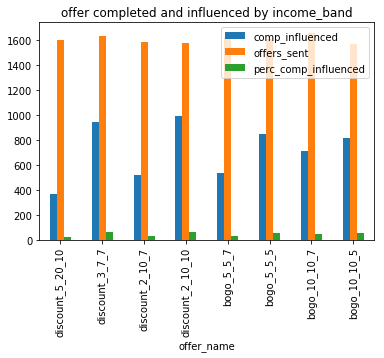

In [359]:
#Step 11
top_ranked_completed_influenced_income_band = get_top_ranked_completed_influenced_category(ranked_completed_influenced_income_band)
top_ranked_completed_influenced_income_band

For the remaining 2 categories I am going to combine the two steps (Steps 10 and Steps 11) into a single function call

## gender
Ranking the completed offers that were influenced by viewing the offer by gender

In [360]:
get_completed_influenced_ranked_by_category('gender')

,offer_name,gender,comp_influenced,offers_sent,perc_comp_influenced
0,discount_5_20_10,F,569,2849,19.97
1,discount_5_20_10,M,619,3877,15.97
2,discount_3_7_7,F,1587,2773,57.23
3,discount_3_7_7,M,1988,3882,51.21
4,discount_2_10_7,F,819,2775,29.51
5,discount_2_10_7,M,993,3856,25.75
6,discount_2_10_10,F,1676,2738,61.21
7,discount_2_10_10,M,2081,3914,53.17
8,bogo_5_5_7,F,848,2819,30.08
9,bogo_5_5_7,M,984,3866,25.45


,offer_name,gender
0,discount_5_20_10,F
2,discount_3_7_7,F
4,discount_2_10_7,F
6,discount_2_10_10,F
8,bogo_5_5_7,F
10,bogo_5_5_5,F
12,bogo_10_10_7,F
14,bogo_10_10_5,F


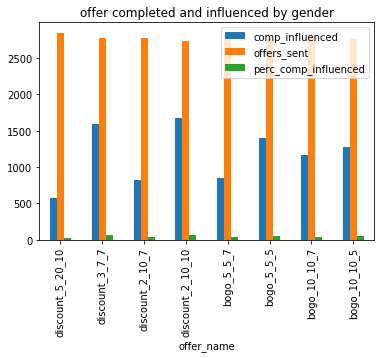

In [361]:
#Step 10 and Step 11 combined
top_ranked_completed_influenced_gender = get_top_ranked_completed_influenced_category(get_completed_influenced_ranked_by_category('gender'))
top_ranked_completed_influenced_gender

### age_band
Ranking the completed offers that were influenced by viewing the offer by age_band

In [362]:
get_completed_influenced_ranked_by_category('age_band')

,offer_name,age_band,comp_influenced,offers_sent,perc_comp_influenced
0,discount_5_20_10,Early Middle Age,184,893,20.60
1,discount_5_20_10,Middle Age,261,1337,19.52
2,discount_5_20_10,Senior,320,1663,19.24
3,discount_5_20_10,Late Middle Age,293,1554,18.85
4,discount_5_20_10,Youth,83,654,12.69
5,discount_5_20_10,Early Adulthood,47,625,7.52
6,discount_3_7_7,Middle Age,700,1232,56.82
7,discount_3_7_7,Senior,916,1688,54.27
8,discount_3_7_7,Late Middle Age,820,1517,54.05
9,discount_3_7_7,Early Middle Age,489,908,53.85


,offer_name,age_band
0,discount_5_20_10,Early Middle Age
6,discount_3_7_7,Middle Age
12,discount_2_10_7,Early Middle Age
18,discount_2_10_10,Late Middle Age
24,bogo_5_5_7,Early Middle Age
30,bogo_5_5_5,Senior
36,bogo_10_10_7,Early Middle Age
42,bogo_10_10_5,Middle Age


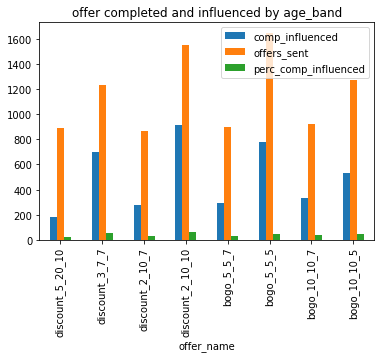

In [363]:
#Step 10 and Step 11 combined
top_ranked_completed_influenced_age_band = get_top_ranked_completed_influenced_category(get_completed_influenced_ranked_by_category('age_band'))
top_ranked_completed_influenced_age_band

### membership_class
Ranking the completed offers that were influenced by viewing the offer by membership_class

In [364]:
get_completed_influenced_ranked_by_category('membership_class')

,offer_name,membership_class,comp_influenced,offers_sent,perc_comp_influenced
0,discount_5_20_10,Gold,363,1383,26.25
1,discount_5_20_10,Platinum,146,740,19.73
2,discount_5_20_10,Silver,416,2475,16.81
3,discount_5_20_10,Diamond,68,423,16.08
4,discount_5_20_10,Bronze,195,1705,11.44
5,discount_3_7_7,Gold,910,1351,67.36
6,discount_3_7_7,Diamond,272,416,65.38
7,discount_3_7_7,Platinum,423,653,64.78
8,discount_3_7_7,Silver,1337,2544,52.56
9,discount_3_7_7,Bronze,633,1691,37.43


,offer_name,membership_class
0,discount_5_20_10,Gold
5,discount_3_7_7,Gold
10,discount_2_10_7,Gold
15,discount_2_10_10,Gold
20,bogo_5_5_7,Platinum
25,bogo_5_5_5,Gold
30,bogo_10_10_7,Gold
35,bogo_10_10_5,Gold


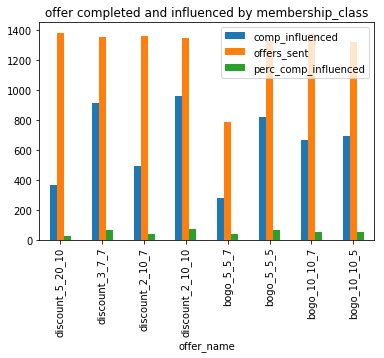

In [365]:
#Step 10 and Step 11 combined
top_ranked_completed_influenced_membership_class = get_top_ranked_completed_influenced_category(get_completed_influenced_ranked_by_category('membership_class'))
top_ranked_completed_influenced_membership_class

Now I will merge all the four dataframes into one dataframe with the top ranked category archetype that completed an offer with influence from viewing the offer

In [366]:
#Step 4
offers_completed_influenced_merged_df = merge_dataframes(top_ranked_completed_influenced_income_band, top_ranked_completed_influenced_gender, top_ranked_completed_influenced_age_band, top_ranked_completed_influenced_membership_class, 'offer_name')
offers_completed_influenced_merged_df

,offer_name,income_band,gender,age_band,membership_class
0,discount_5_20_10,High,F,Early Middle Age,Gold
1,discount_3_7_7,Upper-middle,F,Middle Age,Gold
2,discount_2_10_7,High,F,Early Middle Age,Gold
3,discount_2_10_10,High,F,Late Middle Age,Gold
4,bogo_5_5_7,High,F,Early Middle Age,Platinum
5,bogo_5_5_5,High,F,Senior,Gold
6,bogo_10_10_7,High,F,Early Middle Age,Gold
7,bogo_10_10_5,High,F,Middle Age,Gold


The findings above contain some interesting observations, one of which is that Females are the leading gender in completing all the offer types. The dataframe below proves that.

In [367]:
#Confirming that Females are the leading gender in completing all offer types
get_completed_influenced_ranked_by_category('gender')

,offer_name,gender,comp_influenced,offers_sent,perc_comp_influenced
0,discount_5_20_10,F,569,2849,19.97
1,discount_5_20_10,M,619,3877,15.97
2,discount_3_7_7,F,1587,2773,57.23
3,discount_3_7_7,M,1988,3882,51.21
4,discount_2_10_7,F,819,2775,29.51
5,discount_2_10_7,M,993,3856,25.75
6,discount_2_10_10,F,1676,2738,61.21
7,discount_2_10_10,M,2081,3914,53.17
8,bogo_5_5_7,F,848,2819,30.08
9,bogo_5_5_7,M,984,3866,25.45


The top_completed_influenced_archetypes() function prints the the top archetypes under each category for each offer type.

In [368]:
#Step 12
#Printing the top archetype under each category for each offer type
def top_completed_influenced_archetypes():
    '''
    Print the top profile archetypes that viewed an offer type
    '''
    for offer in offers_completed_influenced_merged_df.offer_name:
        print('The top profile archetypes that completed the "{}" offer after being influenced by viewing the offer received have the following attributes: '.format(offer))
        print('gender: {}'.format(str(list(offers_completed_influenced_merged_df[offers_completed_influenced_merged_df['offer_name'] == offer]['gender'])[0])))
        print('age_band: {}'.format(str(list(offers_completed_influenced_merged_df[offers_completed_influenced_merged_df['offer_name'] == offer]['age_band'])[0])))
        print('income_band: {}, and'.format(str(list(offers_completed_influenced_merged_df[offers_completed_influenced_merged_df['offer_name'] == offer]['income_band'])[0])))
        print('membership_class: {}.'.format(str(list(offers_completed_influenced_merged_df[offers_completed_influenced_merged_df['offer_name'] == offer]['membership_class'])[0])))
        print('\n')

In [369]:
top_completed_influenced_archetypes()

The top profile archetypes that completed the "discount_5_20_10" offer after being influenced by viewing the offer received have the following attributes: 
gender: F
age_band: Early Middle Age
income_band: High, and
membership_class: Gold.


The top profile archetypes that completed the "discount_3_7_7" offer after being influenced by viewing the offer received have the following attributes: 
gender: F
age_band: Middle Age
income_band: Upper-middle, and
membership_class: Gold.


The top profile archetypes that completed the "discount_2_10_7" offer after being influenced by viewing the offer received have the following attributes: 
gender: F
age_band: Early Middle Age
income_band: High, and
membership_class: Gold.


The top profile archetypes that completed the "discount_2_10_10" offer after being influenced by viewing the offer received have the following attributes: 
gender: F
age_band: Late Middle Age
income_band: High, and
membership_class: Gold.


The top profile archetypes that co

The next step in the analysis is to:
- Get the count of profiles that match exactly ALL the archetypes that completed an offer after being influenced
- Get the list of profiles that match exactly ALL the archetypes that completed an offer after being influenced

For this I will use my Step 13 function (find_archetype_profiles_completed_influenced()) which is similar to the find_archetype_profiles() function already defined in Step 6 but looks up the matching profiles in a different dataframe this time around

In [370]:
#step 13
def find_archetype_profiles_completed_influenced(offer):
    '''
    INPUT:
    offer - the offer name
    
    OUTPUT:
    number of profiles in dataset matching ALL the top_view_archetypes per offer
    List of profile id's in dataset matching ALL the top_view_archetypes per offer
    
    '''
    offers_completed_influenced_subset_df = offers_completed_influenced_merged_df[offers_completed_influenced_merged_df['offer_name'] == offer]
    offer_df = pd.DataFrame(profile[(profile['gender'] == list(offers_completed_influenced_subset_df.gender)[0]) & 
                                           (profile['age_band'] == list(offers_completed_influenced_subset_df.age_band)[0]) & 
                                           (profile['income_band'] == list(offers_completed_influenced_subset_df.income_band)[0]) & 
                                           (profile['membership_class'] == list(offers_completed_influenced_subset_df.membership_class)[0])])
    best_archetypes = list(offer_df.id)
    best_archetypes_count = len(best_archetypes)
    
    return best_archetypes_count, best_archetypes

In [371]:
#Step 13
#Get the count and list of profiles that match exactly ALL the archetypes that completed an offer after being influenced
find_archetype_profiles_completed_influenced("discount_5_20_10")

(20,
 ['5084c3bf96464d63bc54f298ce45aef0',
  'b427c95a76904412885fa43e1b6db748',
  '5eb5877aa40744bdb8b147b60295dd61',
  'd61af4fe2054410e9de5825f01d27141',
  '162f5e28092d48d4b37507159a82cf16',
  '4adca6b0329140879c17601716a03e33',
  '5cca371ebf3a4f3aa349e6736d3bc096',
  'aaa88e429f654c6295d47ae156636fa0',
  '33b72f542d964a07b287e69d33eb380f',
  'de0945c55cec445aa4d4132d3c6118d3',
  'c0ed6d30eade4c5d806348ac2d43a16e',
  'de8e51239af349da8412afe26b471f93',
  '5f0dbe20f801408480b7e9f086ba09c3',
  '7e9387535eef47bc8e2efc3263be69de',
  '62fc04236fbd4ea9a8402f0cca70942d',
  'decf7bb9b61c46b59763362e36b046c3',
  '3548505401f44bc79c3f71980d8731fe',
  '35b3206b05304a518114bee3e113af09',
  '14462e564e044822b4b29684512ee428',
  'd4b620d3f4be4a7187245c6b571d0f91'])

In [372]:
#Step 13
#Get the count and list of profiles that match exactly ALL the archetypes that completed an offer after being influenced
find_archetype_profiles_completed_influenced("discount_3_7_7")

(72,
 ['8c7df0c393db488aac3e58b06a7ea5f9',
  'e737ff591120415581ddbe817b8c82ca',
  'd72d201be5794279aa716d8ad82b8d90',
  '338c28f32c5944a99a0529be26d145dd',
  '7195944f0cc34115b0a5e7b4a62055f2',
  '0b99c75c3e0e424fafe2975a64d66e00',
  'e117e1d4f24943c7b1db4148e17d5680',
  '523e2d85f3d94eefbca7970e2b16b234',
  'e70d2311d88c41b8abd04bb3e3039e91',
  '94bbb6006dbb49279728a9c0df4ac989',
  '886a279ebca346daa13bcfd1aa0d8fae',
  '9a457da3a65041a8bae46501d29c2c5a',
  'e54bb450866048d7b8dd740a6746e554',
  '8ed5af89308d4dae98b33701331926ad',
  '4788579ab245498e86c76354d69c03dc',
  '8b0b0b61299343ceb6a4bede74aecd43',
  'c708650a65a345b8bacab8db622458d8',
  '4acef5f30b3c468facf21c59294d4285',
  'a08eae366ff245f3bcba710e73899db0',
  'a20c4cf47deb418f8e995c9015f15fda',
  '8c53deaf7e8f4e8b88a8fc09dd9221f4',
  '0978745a7e524deeabd326d6e5a13d0c',
  '98e2c9e8ee564e5caa384f0829fbcac8',
  'fe466882b4d645e48789d7f726e052fe',
  '22c01c0918664a3788e4dbbac842936d',
  'f7a4d1d7beea4c049bfc99e1932f340d',
  'f3ac

In [373]:
#Step 13
#Get the count and list of profiles that match exactly ALL the archetypes that completed an offer after being influenced
find_archetype_profiles_completed_influenced("discount_2_10_7")

(20,
 ['5084c3bf96464d63bc54f298ce45aef0',
  'b427c95a76904412885fa43e1b6db748',
  '5eb5877aa40744bdb8b147b60295dd61',
  'd61af4fe2054410e9de5825f01d27141',
  '162f5e28092d48d4b37507159a82cf16',
  '4adca6b0329140879c17601716a03e33',
  '5cca371ebf3a4f3aa349e6736d3bc096',
  'aaa88e429f654c6295d47ae156636fa0',
  '33b72f542d964a07b287e69d33eb380f',
  'de0945c55cec445aa4d4132d3c6118d3',
  'c0ed6d30eade4c5d806348ac2d43a16e',
  'de8e51239af349da8412afe26b471f93',
  '5f0dbe20f801408480b7e9f086ba09c3',
  '7e9387535eef47bc8e2efc3263be69de',
  '62fc04236fbd4ea9a8402f0cca70942d',
  'decf7bb9b61c46b59763362e36b046c3',
  '3548505401f44bc79c3f71980d8731fe',
  '35b3206b05304a518114bee3e113af09',
  '14462e564e044822b4b29684512ee428',
  'd4b620d3f4be4a7187245c6b571d0f91'])

In [374]:
#Step 13
#Get the count and list of profiles that match exactly ALL the archetypes that completed an offer after being influenced
find_archetype_profiles_completed_influenced("discount_2_10_10")

(207,
 ['791ffe6d3dc848d2b233129a8096f7ab',
  '73c157a4b8e342fcb5d8479d8cb41e81',
  'aec532a91d9948cb828cc657fa27fce2',
  'b7658a8eab2f42668a9d66499b001e88',
  '7da4476ec7234c0fa8f05d2336669212',
  'd11e7279219b418eb0133758d88ee285',
  '5979ee1e3e744c98afd9f72d9be32546',
  'ec290c4f5c204a4c85f256ee190bd583',
  '309e6ef35e8746ec9031a781304bd5cd',
  '0091d2b6a5ea4defaa8393e4e816db60',
  'df3da7cfcf614b3481b65c89657994ed',
  '3938125799fc4ebca4d77ca64701926e',
  '1792e4aafac94412ae1cd299353c8e15',
  '2481f1fcfbcb4b288e5a03af02d95373',
  'bd7b13b7520b4bd1aed39c026ebb9116',
  '4fa5fba731c94e74918af175bf6f6bac',
  '72f6338d8b124f06be857d656019e0f8',
  '56630668a08842a38f32bf4f7bfa4125',
  '147be99d763240b4b7cbe0e024693807',
  'cd548ef6e88b4b78844ead60c8c628c5',
  '690ce015f65549f693d69593f3bd4663',
  'e309916d14da4d85838e81462faee824',
  'abf29a94ba3d4648869ad7505d863e22',
  '80242cc3d985484fbeeeb7d3cf828b71',
  '40add65eeccb484eb5567ac2c81601f2',
  '2e40baf0355a41329025e8da10bc7c54',
  '526

In [375]:
#Step 13
#Get the count and list of profiles that match exactly ALL the archetypes that completed an offer after being influenced
find_archetype_profiles_completed_influenced("bogo_5_5_7")

(15,
 ['f5e705aa4a81404abe294559f1904fb7',
  '5d5a65281fea4922aba7fbc22dcf4f4b',
  'd7dd26d7142d4e51b63770cf9db2f91f',
  '464fcd7b30524d6d9e94c6cabcd106e1',
  '906a503983444d939dbb4c97e34ba9d2',
  'e6883e7ddd874cfdbf8fe14152859e78',
  'a75203da0a9b45dc968320ae331272c4',
  '035d5aa3c23a4059ae663b4c07aa26ce',
  'cc8812db238a4bb9962dbef576925c5b',
  'd3e15aa9c2a74610aad1c4f87aab44c7',
  '878a89abc3bd43a8841629c4e84187aa',
  '3396faea6acd42538d1ab5f76ba1a942',
  '2520c1ca400d43f4bf52ed6f482a6a75',
  '7106e78bb41f4e5fab74c2c9cf1e459f',
  '7103a340ed8244e1bee58a9639b7678b'])

In [376]:
#Step 13
#Get the count and list of profiles that match exactly ALL the archetypes that completed an offer after being influenced
find_archetype_profiles_completed_influenced("bogo_5_5_5")

(221,
 ['fe8264108d5b4f198453bbb1fa7ca6c9',
  '3f4e408b0b2d4ea89dd16d7437d867c1',
  '5fc96150a4994e3c982e723d06d35e8b',
  '56163abfe5a848debe17c970e7f0c2d1',
  '1c05e4a68fc04d3da27454cb7eaa6144',
  '4ac501588722457a8bc357dc2a500aae',
  '1cb9e98e7a29426eb30becdf850727d0',
  'ac1cc98adbb3419db722ecbdb1583426',
  'b4c29d77c6d045698bf125545d1520f8',
  '0ce0ba52448e482590a6ddd885050b3d',
  '4d5c56fde0e440e1bb838a86a26726fe',
  'bc6f88a8565a43f1883155c8f359bcb0',
  'b1f4e2cbbdd6480699e0f0a355822f49',
  'f3a24f76c9f649388133fc430c0726b9',
  '67819e7df4754ccc8e3386db19411ed1',
  '4706d17c79434626a92481776335fc61',
  'd19849e046cc441fb7cfc4c8a68dbf6d',
  '028c88a958e54c36a31c4800fd6e887b',
  'b1913d90251b4387888ee429bf0209ef',
  '288bd96665ae45c287dec85634f318dd',
  '6006641a7b15444fae1ae0a7e27a88dd',
  '76bd8ff0850b46c3bb5b309fb44c4b81',
  '50e9743f9ba744c8b12ee3b68dffa27d',
  '1e949fc1f3fe4c49af2bbe36e1b8cdf4',
  '5635bb18ab9c4a048311f91f803138f1',
  '5ddf4a03ebfc442b8e3963d7ad7025e0',
  'eeb

In [377]:
#Step 13
#Get the count and list of profiles that match exactly ALL the archetypes that completed an offer after being influenced
find_archetype_profiles_completed_influenced("bogo_10_10_7")

(20,
 ['5084c3bf96464d63bc54f298ce45aef0',
  'b427c95a76904412885fa43e1b6db748',
  '5eb5877aa40744bdb8b147b60295dd61',
  'd61af4fe2054410e9de5825f01d27141',
  '162f5e28092d48d4b37507159a82cf16',
  '4adca6b0329140879c17601716a03e33',
  '5cca371ebf3a4f3aa349e6736d3bc096',
  'aaa88e429f654c6295d47ae156636fa0',
  '33b72f542d964a07b287e69d33eb380f',
  'de0945c55cec445aa4d4132d3c6118d3',
  'c0ed6d30eade4c5d806348ac2d43a16e',
  'de8e51239af349da8412afe26b471f93',
  '5f0dbe20f801408480b7e9f086ba09c3',
  '7e9387535eef47bc8e2efc3263be69de',
  '62fc04236fbd4ea9a8402f0cca70942d',
  'decf7bb9b61c46b59763362e36b046c3',
  '3548505401f44bc79c3f71980d8731fe',
  '35b3206b05304a518114bee3e113af09',
  '14462e564e044822b4b29684512ee428',
  'd4b620d3f4be4a7187245c6b571d0f91'])

In [378]:
#Step 13
#Get the count and list of profiles that match exactly ALL the archetypes that completed an offer after being influenced
find_archetype_profiles_completed_influenced("bogo_10_10_5")

(164,
 ['3a1242dda16248728e350c4bdeb21972',
  '8a37057f57c4495fb98dfcc8b909b09f',
  'f8756fc0eea24e7ba3ccd846efc4d0d5',
  '63682fd0e2454fe098a3aad2c76e0054',
  '11d7a9296e35432f8a34b21e337529fb',
  '352ccf90feeb4c92a54834c7ad2b66bf',
  '02c6daf74a49491ca397f105ef944784',
  '8087bee1c6164205804a1e5459138752',
  '8981e545b60a4a33a060cdc25c4e7ada',
  'ad16351ea0c44654979d30c880df4227',
  '48a05a4f4ac5402fa3d1ec33ae052db4',
  '8cb835dd91384cbba5d0b069da2528c7',
  '3ad56441bfc14636832f038a2d52419e',
  'ec2a37b64f6a454aa1967b1a171eca1a',
  '9f02eeb4d5d2474c96b1e3b0253a0df9',
  'df25bf15b89647208cbb9c186eeea518',
  '07805efd53494b8fa08f661e311dad9e',
  'd820adac939d46078131f147d99d3f85',
  '1d36a7ddbd114574a804c5c4eb2ecb4d',
  'd125605ab1244b8fba57840cbe095f81',
  '761e483441e942d6ad4a8c84a79605ce',
  '41432b5e320846288781470dcc1ce194',
  'd1c675320dcc4666a9300edc39965235',
  'b93ac0e7c56a4bb8a4b379cc21befcba',
  '11eb0a3d24ed4032b2cc358b4508c85d',
  'd438a838e9f74fa99c3a53f53d73afd4',
  '303

Now for the final question, I am going to find the top archetypes per each category and the list and count of such persons that completed the offer anyway WITHOUT VIEWING or BEFORE VIEWING the offer that they had received.

Firstly I am going to subset the completed dataframe for only the persons that completed the offer without viewing the offer

offer_completed_events
completed_without_viewing_informational_0_0_4

In [379]:
offer_completed_events.head(1)

,offer_name,person,gender,event,offer_id,age,membership_class,income_band,age_band,offer_type,duration_in_hours,time
0,bogo_10_10_5,0020c2b971eb4e9188eac86d93036a77,F,offer completed,4d5c57ea9a6940dd891ad53e9dbe8da0,59,Gold,High,Late Middle Age,bogo,120,510


In [380]:
offers_completed_influenced_merged_df.offer_name

0    discount_5_20_10
1      discount_3_7_7
2     discount_2_10_7
3    discount_2_10_10
4          bogo_5_5_7
5          bogo_5_5_5
6        bogo_10_10_7
7        bogo_10_10_5
Name: offer_name, dtype: object

In [381]:
without_viewewing_discount_5_20_10 = offer_completed_events[(offer_completed_events['offer_name'] == 'discount_5_20_10') & (offer_completed_events['person'].isin (completed_without_viewing_discount_5_20_10))]

In [382]:
#Step 14
#Subset offer_completed_events dataframe with just the users who completed an offer but did not view the offer they received
def completed_without_viewing(offer , user_list):
    '''
    INPUT:
    offer - the offer that we are subsetting the rows that completed an offer without viewing from the offer_completed_events dataframe
    user_list - list of users that completeted the given offer without viewing the received offer
    
    OUTPUT:
    completed_without_viewing_df - a dataframe subset of the offer_completed_events of users who completed an offer but did not view the offer    
    '''
    completed_without_viewing_df = offer_completed_events[(offer_completed_events['offer_name'] == offer) & (offer_completed_events['person'].isin(user_list))]
    
    print(completed_without_viewing_df.shape)

    return completed_without_viewing_df

In [383]:
#Step 14
#Subset offer_completed_events dataframe with just the users who completed an offer but did not view the offer they received
without_viewewing_discount_5_20_10 = completed_without_viewing('discount_5_20_10' , completed_without_viewing_discount_5_20_10)
without_viewewing_discount_5_20_10.head(2)

(1492, 12)


,offer_name,person,gender,event,offer_id,age,membership_class,income_band,age_band,offer_type,duration_in_hours,time
24999,discount_5_20_10,003d66b6608740288d6cc97a6903f4f0,F,offer completed,0b1e1539f2cc45b7b9fa7c272da2e1d7,26,Silver,Upper-middle,Early Adulthood,discount,240,696
25000,discount_5_20_10,0056df74b63b4298809f0b375a304cf4,M,offer completed,0b1e1539f2cc45b7b9fa7c272da2e1d7,54,Gold,High,Middle Age,discount,240,414


In [384]:
#Step 14
#Subset offer_completed_events dataframe with just the users who completed an offer but did not view the offer they received
without_viewewing_discount_3_7_7 = completed_without_viewing('discount_3_7_7' , completed_without_viewing_discount_3_7_7)
without_viewewing_discount_3_7_7.head(2)

(105, 12)


,offer_name,person,gender,event,offer_id,age,membership_class,income_band,age_band,offer_type,duration_in_hours,time
20865,discount_3_7_7,02b5aa5725f94bcb94ca58208015b7bc,M,offer completed,2298d6c36e964ae4a3e7e9706d1fb8c2,65,Gold,Low,Late Middle Age,discount,168,438
20986,discount_3_7_7,0b83ad12131140a9bd1b2e5e1ae457e4,F,offer completed,2298d6c36e964ae4a3e7e9706d1fb8c2,44,Platinum,Low-middle,Early Middle Age,discount,168,510


In [385]:
#Step 14
#Subset offer_completed_events dataframe with just the users who completed an offer but did not view the offer they received
without_viewewing_discount_2_10_7 = completed_without_viewing('discount_2_10_7' , completed_without_viewing_discount_2_10_7)
without_viewewing_discount_2_10_7.head(2)

(1048, 12)


,offer_name,person,gender,event,offer_id,age,membership_class,income_band,age_band,offer_type,duration_in_hours,time
17448,discount_2_10_7,0009655768c64bdeb2e877511632db8f,M,offer completed,2906b810c7d4411798c6938adc9daaa5,33,Silver,Upper-middle,Early Adulthood,discount,168,576
17453,discount_2_10_7,00c2f812f4604c8893152a5c6572030e,F,offer completed,2906b810c7d4411798c6938adc9daaa5,58,Bronze,High,Late Middle Age,discount,168,582


In [386]:
#Step 14
#Subset offer_completed_events dataframe with just the users who completed an offer but did not view the offer they received
without_viewewing_discount_2_10_10 = completed_without_viewing('discount_2_10_10' , completed_without_viewing_discount_2_10_10)
without_viewewing_discount_2_10_10.head(2)

(94, 12)


,offer_name,person,gender,event,offer_id,age,membership_class,income_band,age_band,offer_type,duration_in_hours,time
13285,discount_2_10_10,04ea45ec66574a618b0918834ee08fed,F,offer completed,fafdcd668e3743c1bb461111dcafc2a4,86,Platinum,Upper-middle,Senior,discount,240,510
13327,discount_2_10_10,07c44df054f241aab553723ed855ca21,F,offer completed,fafdcd668e3743c1bb461111dcafc2a4,58,Platinum,Low-middle,Late Middle Age,discount,240,408


In [387]:
#Step 14
#Subset offer_completed_events dataframe with just the users who completed an offer but did not view the offer they received
without_viewewing_bogo_5_5_7 = completed_without_viewing('bogo_5_5_7' , completed_without_viewing_bogo_5_5_7)
without_viewewing_bogo_5_5_7.head(2)

(1230, 12)


,offer_name,person,gender,event,offer_id,age,membership_class,income_band,age_band,offer_type,duration_in_hours,time
9575,bogo_5_5_7,005500a7188546ff8a767329a2f7c76a,M,offer completed,9b98b8c7a33c4b65b9aebfe6a799e6d9,56,Silver,Low,Late Middle Age,bogo,168,582
9578,bogo_5_5_7,00840a2ca5d2408e982d56544dc14ffd,M,offer completed,9b98b8c7a33c4b65b9aebfe6a799e6d9,26,Diamond,Low-middle,Early Adulthood,bogo,168,522


In [388]:
#Step 14
#Subset offer_completed_events dataframe with just the users who completed an offer but did not view the offer they received
without_viewewing_bogo_5_5_5 = completed_without_viewing('bogo_5_5_5' , completed_without_viewing_bogo_5_5_5)
without_viewewing_bogo_5_5_5.head(2)

(81, 12)


,offer_name,person,gender,event,offer_id,age,membership_class,income_band,age_band,offer_type,duration_in_hours,time
6032,bogo_5_5_5,01a202a9021e40aeaa5451a5d134c16c,F,offer completed,f19421c1d4aa40978ebb69ca19b0e20d,74,Gold,High,Senior,bogo,120,618
6079,bogo_5_5_5,055a06b9a6ad42fcaa1fe7706b5e21aa,F,offer completed,f19421c1d4aa40978ebb69ca19b0e20d,63,Bronze,Upper-middle,Late Middle Age,bogo,120,582


In [389]:
#Step 14
#Subset offer_completed_events dataframe with just the users who completed an offer but did not view the offer they received
without_viewewing_bogo_10_10_7 = completed_without_viewing('bogo_10_10_7' , completed_without_viewing_bogo_10_10_7)
without_viewewing_bogo_10_10_7.head(2)

(333, 12)


,offer_name,person,gender,event,offer_id,age,membership_class,income_band,age_band,offer_type,duration_in_hours,time
2865,bogo_10_10_7,004c5799adbf42868b9cff0396190900,M,offer completed,ae264e3637204a6fb9bb56bc8210ddfd,54,Gold,High,Middle Age,bogo,168,336
2868,bogo_10_10_7,00b3400e4ff64ee68ce9ada1d0c222f0,M,offer completed,ae264e3637204a6fb9bb56bc8210ddfd,62,Gold,Upper-middle,Late Middle Age,bogo,168,264


In [390]:
#Step 14
#Subset offer_completed_events dataframe with just the users who completed an offer but did not view the offer they received
without_viewewing_bogo_10_10_5 = completed_without_viewing('bogo_10_10_5' , completed_without_viewing_bogo_10_10_5)
without_viewewing_bogo_10_10_5.head(2)

(60, 12)


,offer_name,person,gender,event,offer_id,age,membership_class,income_band,age_band,offer_type,duration_in_hours,time
1,bogo_10_10_5,00715b6e55c3431cb56ff7307eb19675,F,offer completed,4d5c57ea9a6940dd891ad53e9dbe8da0,58,Silver,High,Late Middle Age,bogo,120,342
67,bogo_10_10_5,061e7367906a4d0087b8e8f2f92a313e,F,offer completed,4d5c57ea9a6940dd891ad53e9dbe8da0,35,Silver,Low-middle,Early Adulthood,bogo,120,606


Now combining all the dataframes for users who completed and offer but did not view the offer

In [391]:
completed_without_viewing = [without_viewewing_discount_5_20_10, without_viewewing_discount_3_7_7, without_viewewing_discount_2_10_7, without_viewewing_discount_2_10_10, without_viewewing_bogo_5_5_7, without_viewewing_bogo_5_5_5, without_viewewing_bogo_10_10_7, without_viewewing_bogo_10_10_5]
completed_without_viewing = pd.concat(completed_without_viewing).reset_index(drop=True)
print(completed_without_viewing.shape)
completed_without_viewing.head()

(4443, 12)


,offer_name,person,gender,event,offer_id,age,membership_class,income_band,age_band,offer_type,duration_in_hours,time
0,discount_5_20_10,003d66b6608740288d6cc97a6903f4f0,F,offer completed,0b1e1539f2cc45b7b9fa7c272da2e1d7,26,Silver,Upper-middle,Early Adulthood,discount,240,696
1,discount_5_20_10,0056df74b63b4298809f0b375a304cf4,M,offer completed,0b1e1539f2cc45b7b9fa7c272da2e1d7,54,Gold,High,Middle Age,discount,240,414
2,discount_5_20_10,0099bf30e4cb4265875266eb3eb25eab,M,offer completed,0b1e1539f2cc45b7b9fa7c272da2e1d7,61,Bronze,Upper-middle,Late Middle Age,discount,240,420
3,discount_5_20_10,00b3400e4ff64ee68ce9ada1d0c222f0,M,offer completed,0b1e1539f2cc45b7b9fa7c272da2e1d7,62,Gold,Upper-middle,Late Middle Age,discount,240,420
4,discount_5_20_10,00b3c376db2a4115af3aef34a02f61d6,M,offer completed,0b1e1539f2cc45b7b9fa7c272da2e1d7,50,Silver,High,Middle Age,discount,240,480


For a complete dataframe of ALL offers that were completed without the influence of an offer I will concatenate the completed_without_viewing dataframe and the offer_completed_not_influenced dataframe from earlier. The offer_completed_not_influenced dataframe contains records of offers completed where the person did view the offer but viewed the offer only after they had already completed the offer. So in this case the view is being regarded as not having influenced the person to complete the offer.

I need to make sure the columns in offer_completed_not_influenced dataframe match those of completed_without_viewing before merging the two dataframes

In [392]:
#Drop 'event_x', 'offer viewed', and 'influenced'columns from offer_completed_not_influenced dataframe
offer_completed_not_influenced = offer_completed_not_influenced.drop(['event_x', 'offer viewed', 'influenced'], axis=1)
offer_completed_not_influenced.shape

(3663, 12)

In [393]:
#Rename 'event_y column to 'event', and 'offer completed' to 'time'
offer_completed_not_influenced = offer_completed_not_influenced.rename(columns = {'event_y': 'event', 'offer completed': 'time'})


In [394]:
#Rearrange the columns in offer_completed_not_influenced to match those from completed_without_viewing dataframe
offer_completed_not_influenced = offer_completed_not_influenced[['offer_name', 'person', 'gender', 'event', 'offer_id', 'age', 'membership_class', 'income_band', 'age_band', 'offer_type', 'duration_in_hours', 'time']]

In [395]:
#Concatenate the two dataframes
completed_without_influence = [completed_without_viewing, offer_completed_not_influenced]
completed_without_influence = pd.concat(completed_without_influence).reset_index(drop=True)
print(completed_without_influence.shape)
completed_without_influence.head(2)

(8106, 12)


,offer_name,person,gender,event,offer_id,age,membership_class,income_band,age_band,offer_type,duration_in_hours,time
0,discount_5_20_10,003d66b6608740288d6cc97a6903f4f0,F,offer completed,0b1e1539f2cc45b7b9fa7c272da2e1d7,26,Silver,Upper-middle,Early Adulthood,discount,240,696
1,discount_5_20_10,0056df74b63b4298809f0b375a304cf4,M,offer completed,0b1e1539f2cc45b7b9fa7c272da2e1d7,54,Gold,High,Middle Age,discount,240,414


The next step is to run the same set of analysis on the completed_without_influence dataframe to come up with the best archetypes for each category for each offer type for persons who would complete an offer type anyways even if they did not receive the offer. This means these persons would transact to the value of an offer difficulty without any offer, therefore Starbucks is not really gaining any additional revenue through extending the offer to them.

In [396]:
#Step 15
def get_completed_without_influence_ranked_by_category(category, df=completed_without_influence):
    '''
    INPUT:
    category - name of the category to rank offer views by
    df - the dataframe with completed offers that were influenced by viewing the offer
    
    OUTPUT:
    ranking df - dataframe with ranked completed offers that were influenced by viewing the offer ranked by the category
    '''
    for offer in get_offers():
        ranking_df = pd.DataFrame(df[df['event'] == 'offer completed'].groupby(['offer_name', category])['event'].count())
        
        ranking_df['offers_sent'] = get_views_ranked_by_category(category)['event']
        
        ranking_df['perc_comp_without_influence'] = ((ranking_df.event/ranking_df.offers_sent)*100).round(2)
        
        ranking_df = ranking_df.sort_values(by=['offer_name', 'perc_comp_without_influence'], ascending=False)
        
        ranking_df = ranking_df.rename(columns = {'event': 'comp_without_influence'})
        
        ranking_unstacked = ranking_df.to_records()
        
        ranking_unstacked_df = pd.DataFrame(ranking_unstacked)
         
    return ranking_unstacked_df

In [397]:
#Step 16
def get_top_ranked_completed_without_influence_category(df):
    top_ranked_without_influence_category = df.drop_duplicates(subset='offer_name', keep='first')
    
    top_ranked_without_influence_category_names = top_ranked_without_influence_category.iloc[:, :2]
    
    top_ranked_without_influence_category.plot.bar(x='offer_name', title = 'offer completed without influence by '+ top_ranked_without_influence_category.columns[1])
    
    return top_ranked_without_influence_category_names

### gender

In [398]:
get_completed_without_influence_ranked_by_category('gender')

,offer_name,gender,comp_without_influence,offers_sent,perc_comp_without_influence
0,discount_5_20_10,F,929,2849,32.61
1,discount_5_20_10,M,827,3877,21.33
2,discount_3_7_7,F,315,2773,11.36
3,discount_3_7_7,M,277,3882,7.14
4,discount_2_10_7,F,799,2775,28.79
5,discount_2_10_7,M,772,3856,20.02
6,discount_2_10_10,F,227,2738,8.29
7,discount_2_10_10,M,264,3914,6.75
8,bogo_5_5_7,F,900,2819,31.93
9,bogo_5_5_7,M,895,3866,23.15


,offer_name,gender
0,discount_5_20_10,F
2,discount_3_7_7,F
4,discount_2_10_7,F
6,discount_2_10_10,F
8,bogo_5_5_7,F
10,bogo_5_5_5,F
12,bogo_10_10_7,F
14,bogo_10_10_5,F


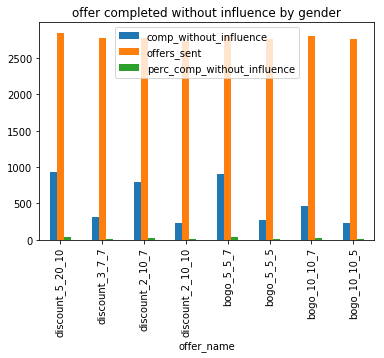

In [399]:
top_ranked_completed_without_influence_gender = get_top_ranked_completed_without_influence_category(get_completed_without_influence_ranked_by_category('gender'))
top_ranked_completed_without_influence_gender

### age_band

In [400]:
get_completed_without_influence_ranked_by_category('age_band')

,offer_name,age_band,comp_without_influence,offers_sent,perc_comp_without_influence
0,discount_5_20_10,Senior,496,1663,29.83
1,discount_5_20_10,Late Middle Age,435,1554,27.99
2,discount_5_20_10,Middle Age,373,1337,27.90
3,discount_5_20_10,Youth,146,654,22.32
4,discount_5_20_10,Early Adulthood,137,625,21.92
5,discount_5_20_10,Early Middle Age,169,893,18.92
6,discount_3_7_7,Early Adulthood,66,618,10.68
7,discount_3_7_7,Late Middle Age,144,1517,9.49
8,discount_3_7_7,Senior,151,1688,8.95
9,discount_3_7_7,Youth,60,692,8.67


,offer_name,age_band
0,discount_5_20_10,Senior
6,discount_3_7_7,Early Adulthood
12,discount_2_10_7,Senior
18,discount_2_10_10,Senior
24,bogo_5_5_7,Early Adulthood
30,bogo_5_5_5,Early Adulthood
36,bogo_10_10_7,Late Middle Age
42,bogo_10_10_5,Senior


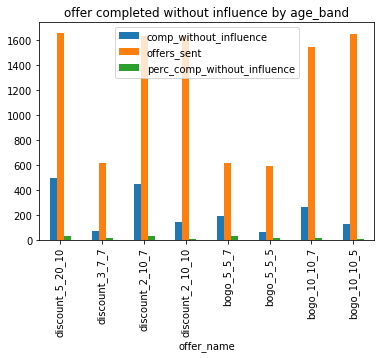

In [401]:
top_ranked_completed_without_influence_age_band = get_top_ranked_completed_without_influence_category(get_completed_without_influence_ranked_by_category('age_band'))
top_ranked_completed_without_influence_age_band

### income_band

In [402]:
get_completed_without_influence_ranked_by_category('income_band')

,offer_name,income_band,comp_without_influence,offers_sent,perc_comp_without_influence
0,discount_5_20_10,High,659,1600,41.19
1,discount_5_20_10,Upper-middle,423,1658,25.51
2,discount_5_20_10,Low-middle,357,1709,20.89
3,discount_5_20_10,Low,317,1759,18.02
4,discount_3_7_7,High,179,1582,11.31
5,discount_3_7_7,Upper-middle,134,1627,8.24
6,discount_3_7_7,Low,139,1695,8.20
7,discount_3_7_7,Low-middle,140,1751,8.00
8,discount_2_10_7,High,515,1583,32.53
9,discount_2_10_7,Upper-middle,408,1632,25.00


,offer_name,income_band
0,discount_5_20_10,High
4,discount_3_7_7,High
8,discount_2_10_7,High
12,discount_2_10_10,High
16,bogo_5_5_7,High
20,bogo_5_5_5,High
24,bogo_10_10_7,High
28,bogo_10_10_5,High


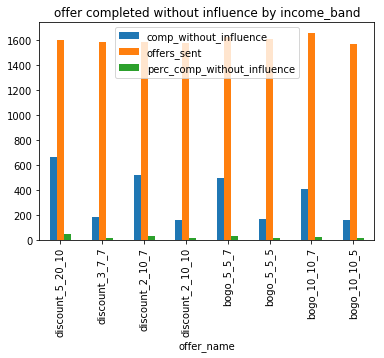

In [403]:
top_ranked_completed_without_influence_income_band = get_top_ranked_completed_without_influence_category(get_completed_without_influence_ranked_by_category('income_band'))
top_ranked_completed_without_influence_income_band

### membership_class

In [404]:
get_completed_without_influence_ranked_by_category('membership_class')

,offer_name,membership_class,comp_without_influence,offers_sent,perc_comp_without_influence
0,discount_5_20_10,Gold,500,1383,36.15
1,discount_5_20_10,Platinum,252,740,34.05
2,discount_5_20_10,Silver,671,2475,27.11
3,discount_5_20_10,Diamond,75,423,17.73
4,discount_5_20_10,Bronze,258,1705,15.13
5,discount_3_7_7,Gold,160,1351,11.84
6,discount_3_7_7,Platinum,74,653,11.33
7,discount_3_7_7,Silver,222,2544,8.73
8,discount_3_7_7,Diamond,33,416,7.93
9,discount_3_7_7,Bronze,103,1691,6.09


,offer_name,membership_class
0,discount_5_20_10,Gold
5,discount_3_7_7,Gold
10,discount_2_10_7,Gold
15,discount_2_10_10,Gold
20,bogo_5_5_7,Gold
25,bogo_5_5_5,Gold
30,bogo_10_10_7,Gold
35,bogo_10_10_5,Gold


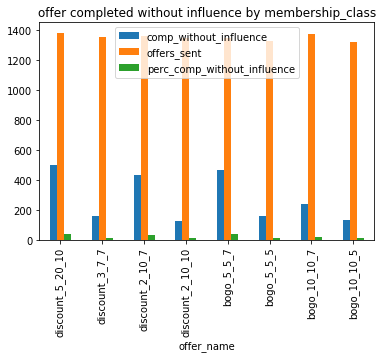

In [405]:
top_ranked_completed_without_influence_membership_class = get_top_ranked_completed_without_influence_category(get_completed_without_influence_ranked_by_category('membership_class'))
top_ranked_completed_without_influence_membership_class

Next step is to merge all the offers_completed_without_influence top archetypes into one dataframe

In [406]:
#Step 4
#Merging all the offers_completed_without_influence top archetypes into one
offers_completed_without_influence_merged_df = merge_dataframes(top_ranked_completed_without_influence_income_band, top_ranked_completed_without_influence_gender, top_ranked_completed_without_influence_age_band, top_ranked_completed_without_influence_membership_class, 'offer_name')
offers_completed_without_influence_merged_df

,offer_name,income_band,gender,age_band,membership_class
0,discount_5_20_10,High,F,Senior,Gold
1,discount_3_7_7,High,F,Early Adulthood,Gold
2,discount_2_10_7,High,F,Senior,Gold
3,discount_2_10_10,High,F,Senior,Gold
4,bogo_5_5_7,High,F,Early Adulthood,Gold
5,bogo_5_5_5,High,F,Early Adulthood,Gold
6,bogo_10_10_7,High,F,Late Middle Age,Gold
7,bogo_10_10_5,High,F,Senior,Gold


Next step is to print out the top archetypes that completed an offer without influence for each category

In [407]:
#Step 17
#Printing the top archetype under each category for each offer type
def top_completed_without_influence_archetypes():
    '''
    Print the top profile archetypes that completed an offer type without influence
    '''
    for offer in offers_completed_without_influence_merged_df.offer_name:
        print('The top profile archetypes that completed the "{}" offer without being influenced have the following attributes: '.format(offer))
        print('gender: {}'.format(str(list(offers_completed_without_influence_merged_df[offers_completed_without_influence_merged_df['offer_name'] == offer]['gender'])[0])))
        print('age_band: {}'.format(str(list(offers_completed_without_influence_merged_df[offers_completed_without_influence_merged_df['offer_name'] == offer]['age_band'])[0])))
        print('income_band: {}, and'.format(str(list(offers_completed_without_influence_merged_df[offers_completed_without_influence_merged_df['offer_name'] == offer]['income_band'])[0])))
        print('membership_class: {}.'.format(str(list(offers_completed_without_influence_merged_df[offers_completed_without_influence_merged_df['offer_name'] == offer]['membership_class'])[0])))
        print('\n')

In [408]:
top_completed_without_influence_archetypes()

The top profile archetypes that completed the "discount_5_20_10" offer without being influenced have the following attributes: 
gender: F
age_band: Senior
income_band: High, and
membership_class: Gold.


The top profile archetypes that completed the "discount_3_7_7" offer without being influenced have the following attributes: 
gender: F
age_band: Early Adulthood
income_band: High, and
membership_class: Gold.


The top profile archetypes that completed the "discount_2_10_7" offer without being influenced have the following attributes: 
gender: F
age_band: Senior
income_band: High, and
membership_class: Gold.


The top profile archetypes that completed the "discount_2_10_10" offer without being influenced have the following attributes: 
gender: F
age_band: Senior
income_band: High, and
membership_class: Gold.


The top profile archetypes that completed the "bogo_5_5_7" offer without being influenced have the following attributes: 
gender: F
age_band: Early Adulthood
income_band: High, a

In [409]:
#step 13
def find_archetype_profiles_completed_without_influence(offer):
    '''
    INPUT:
    offer - the offer name
    
    OUTPUT:
    number of profiles in dataset matching ALL the top_view_archetypes per offer
    List of profile id's in dataset matching ALL the top_view_archetypes per offer
    
    '''
    offers_completed_without_influence_subset_df = offers_completed_without_influence_merged_df[offers_completed_without_influence_merged_df['offer_name'] == offer]
    offer_df = pd.DataFrame(profile[(profile['gender'] == list(offers_completed_without_influence_subset_df.gender)[0]) & 
                                           (profile['age_band'] == list(offers_completed_without_influence_subset_df.age_band)[0]) & 
                                           (profile['income_band'] == list(offers_completed_without_influence_subset_df.income_band)[0]) & 
                                           (profile['membership_class'] == list(offers_completed_without_influence_subset_df.membership_class)[0])])
    best_archetypes = list(offer_df.id)
    best_archetypes_count = len(best_archetypes)
    
    return best_archetypes_count, best_archetypes

In [410]:
offers_completed_without_influence_merged_df.offer_name

0    discount_5_20_10
1      discount_3_7_7
2     discount_2_10_7
3    discount_2_10_10
4          bogo_5_5_7
5          bogo_5_5_5
6        bogo_10_10_7
7        bogo_10_10_5
Name: offer_name, dtype: object

In [411]:
find_archetype_profiles_completed_without_influence('discount_5_20_10')

(221,
 ['fe8264108d5b4f198453bbb1fa7ca6c9',
  '3f4e408b0b2d4ea89dd16d7437d867c1',
  '5fc96150a4994e3c982e723d06d35e8b',
  '56163abfe5a848debe17c970e7f0c2d1',
  '1c05e4a68fc04d3da27454cb7eaa6144',
  '4ac501588722457a8bc357dc2a500aae',
  '1cb9e98e7a29426eb30becdf850727d0',
  'ac1cc98adbb3419db722ecbdb1583426',
  'b4c29d77c6d045698bf125545d1520f8',
  '0ce0ba52448e482590a6ddd885050b3d',
  '4d5c56fde0e440e1bb838a86a26726fe',
  'bc6f88a8565a43f1883155c8f359bcb0',
  'b1f4e2cbbdd6480699e0f0a355822f49',
  'f3a24f76c9f649388133fc430c0726b9',
  '67819e7df4754ccc8e3386db19411ed1',
  '4706d17c79434626a92481776335fc61',
  'd19849e046cc441fb7cfc4c8a68dbf6d',
  '028c88a958e54c36a31c4800fd6e887b',
  'b1913d90251b4387888ee429bf0209ef',
  '288bd96665ae45c287dec85634f318dd',
  '6006641a7b15444fae1ae0a7e27a88dd',
  '76bd8ff0850b46c3bb5b309fb44c4b81',
  '50e9743f9ba744c8b12ee3b68dffa27d',
  '1e949fc1f3fe4c49af2bbe36e1b8cdf4',
  '5635bb18ab9c4a048311f91f803138f1',
  '5ddf4a03ebfc442b8e3963d7ad7025e0',
  'eeb

In [412]:
find_archetype_profiles_completed_without_influence('discount_3_7_7')

(0, [])

In [413]:
find_archetype_profiles_completed_without_influence('discount_2_10_7')

(221,
 ['fe8264108d5b4f198453bbb1fa7ca6c9',
  '3f4e408b0b2d4ea89dd16d7437d867c1',
  '5fc96150a4994e3c982e723d06d35e8b',
  '56163abfe5a848debe17c970e7f0c2d1',
  '1c05e4a68fc04d3da27454cb7eaa6144',
  '4ac501588722457a8bc357dc2a500aae',
  '1cb9e98e7a29426eb30becdf850727d0',
  'ac1cc98adbb3419db722ecbdb1583426',
  'b4c29d77c6d045698bf125545d1520f8',
  '0ce0ba52448e482590a6ddd885050b3d',
  '4d5c56fde0e440e1bb838a86a26726fe',
  'bc6f88a8565a43f1883155c8f359bcb0',
  'b1f4e2cbbdd6480699e0f0a355822f49',
  'f3a24f76c9f649388133fc430c0726b9',
  '67819e7df4754ccc8e3386db19411ed1',
  '4706d17c79434626a92481776335fc61',
  'd19849e046cc441fb7cfc4c8a68dbf6d',
  '028c88a958e54c36a31c4800fd6e887b',
  'b1913d90251b4387888ee429bf0209ef',
  '288bd96665ae45c287dec85634f318dd',
  '6006641a7b15444fae1ae0a7e27a88dd',
  '76bd8ff0850b46c3bb5b309fb44c4b81',
  '50e9743f9ba744c8b12ee3b68dffa27d',
  '1e949fc1f3fe4c49af2bbe36e1b8cdf4',
  '5635bb18ab9c4a048311f91f803138f1',
  '5ddf4a03ebfc442b8e3963d7ad7025e0',
  'eeb

In [414]:
find_archetype_profiles_completed_without_influence('discount_2_10_10')

(221,
 ['fe8264108d5b4f198453bbb1fa7ca6c9',
  '3f4e408b0b2d4ea89dd16d7437d867c1',
  '5fc96150a4994e3c982e723d06d35e8b',
  '56163abfe5a848debe17c970e7f0c2d1',
  '1c05e4a68fc04d3da27454cb7eaa6144',
  '4ac501588722457a8bc357dc2a500aae',
  '1cb9e98e7a29426eb30becdf850727d0',
  'ac1cc98adbb3419db722ecbdb1583426',
  'b4c29d77c6d045698bf125545d1520f8',
  '0ce0ba52448e482590a6ddd885050b3d',
  '4d5c56fde0e440e1bb838a86a26726fe',
  'bc6f88a8565a43f1883155c8f359bcb0',
  'b1f4e2cbbdd6480699e0f0a355822f49',
  'f3a24f76c9f649388133fc430c0726b9',
  '67819e7df4754ccc8e3386db19411ed1',
  '4706d17c79434626a92481776335fc61',
  'd19849e046cc441fb7cfc4c8a68dbf6d',
  '028c88a958e54c36a31c4800fd6e887b',
  'b1913d90251b4387888ee429bf0209ef',
  '288bd96665ae45c287dec85634f318dd',
  '6006641a7b15444fae1ae0a7e27a88dd',
  '76bd8ff0850b46c3bb5b309fb44c4b81',
  '50e9743f9ba744c8b12ee3b68dffa27d',
  '1e949fc1f3fe4c49af2bbe36e1b8cdf4',
  '5635bb18ab9c4a048311f91f803138f1',
  '5ddf4a03ebfc442b8e3963d7ad7025e0',
  'eeb

In [415]:
find_archetype_profiles_completed_without_influence('bogo_5_5_7')

(0, [])

In [416]:
find_archetype_profiles_completed_without_influence('bogo_5_5_5')

(0, [])

In [417]:
find_archetype_profiles_completed_without_influence('bogo_10_10_7')

(207,
 ['791ffe6d3dc848d2b233129a8096f7ab',
  '73c157a4b8e342fcb5d8479d8cb41e81',
  'aec532a91d9948cb828cc657fa27fce2',
  'b7658a8eab2f42668a9d66499b001e88',
  '7da4476ec7234c0fa8f05d2336669212',
  'd11e7279219b418eb0133758d88ee285',
  '5979ee1e3e744c98afd9f72d9be32546',
  'ec290c4f5c204a4c85f256ee190bd583',
  '309e6ef35e8746ec9031a781304bd5cd',
  '0091d2b6a5ea4defaa8393e4e816db60',
  'df3da7cfcf614b3481b65c89657994ed',
  '3938125799fc4ebca4d77ca64701926e',
  '1792e4aafac94412ae1cd299353c8e15',
  '2481f1fcfbcb4b288e5a03af02d95373',
  'bd7b13b7520b4bd1aed39c026ebb9116',
  '4fa5fba731c94e74918af175bf6f6bac',
  '72f6338d8b124f06be857d656019e0f8',
  '56630668a08842a38f32bf4f7bfa4125',
  '147be99d763240b4b7cbe0e024693807',
  'cd548ef6e88b4b78844ead60c8c628c5',
  '690ce015f65549f693d69593f3bd4663',
  'e309916d14da4d85838e81462faee824',
  'abf29a94ba3d4648869ad7505d863e22',
  '80242cc3d985484fbeeeb7d3cf828b71',
  '40add65eeccb484eb5567ac2c81601f2',
  '2e40baf0355a41329025e8da10bc7c54',
  '526

In [418]:
find_archetype_profiles_completed_without_influence('bogo_10_10_5')

(221,
 ['fe8264108d5b4f198453bbb1fa7ca6c9',
  '3f4e408b0b2d4ea89dd16d7437d867c1',
  '5fc96150a4994e3c982e723d06d35e8b',
  '56163abfe5a848debe17c970e7f0c2d1',
  '1c05e4a68fc04d3da27454cb7eaa6144',
  '4ac501588722457a8bc357dc2a500aae',
  '1cb9e98e7a29426eb30becdf850727d0',
  'ac1cc98adbb3419db722ecbdb1583426',
  'b4c29d77c6d045698bf125545d1520f8',
  '0ce0ba52448e482590a6ddd885050b3d',
  '4d5c56fde0e440e1bb838a86a26726fe',
  'bc6f88a8565a43f1883155c8f359bcb0',
  'b1f4e2cbbdd6480699e0f0a355822f49',
  'f3a24f76c9f649388133fc430c0726b9',
  '67819e7df4754ccc8e3386db19411ed1',
  '4706d17c79434626a92481776335fc61',
  'd19849e046cc441fb7cfc4c8a68dbf6d',
  '028c88a958e54c36a31c4800fd6e887b',
  'b1913d90251b4387888ee429bf0209ef',
  '288bd96665ae45c287dec85634f318dd',
  '6006641a7b15444fae1ae0a7e27a88dd',
  '76bd8ff0850b46c3bb5b309fb44c4b81',
  '50e9743f9ba744c8b12ee3b68dffa27d',
  '1e949fc1f3fe4c49af2bbe36e1b8cdf4',
  '5635bb18ab9c4a048311f91f803138f1',
  '5ddf4a03ebfc442b8e3963d7ad7025e0',
  'eeb

# The end...